# G-Tube Project

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# To-do

# 1 hour before : ('first pause')
# 1 hour after : ('second pause')
# Notes - induction -> closing for During. Variable amout of time
# create new variable: cStO2, rStO2

## Background

Premature infants undergo G-Tube Surgery. Data was collected for around 24 hours before and 24 hours after (not exact). This data was collected using NIRS which interfaced with the Moberg Machine. The first NIRS probe is placed on the infant's brain and the second probe is placed in the flank for renal StO2. 

EEG leads done by nurses. Pause monitoring for transport period. Stopped right before transport, restarted as soon as baby gets put onto the table.
Pauses (max 20 mins).

For this project, since there is no specific hypothesis, data will be visualized and exploratory data analysis will be used to better inform further analysis.

## Data Preparation and Cleaning

Data was downloaded from a private Google Drive server and file names were de-identified with this naming scheme: GTP001, GTP002, etc. Each file is concatenated into one dataframe for easier analysis.
Only relevant data was filtered out from the raw dataset to form the analysis dataframe. FTOE was calcualted from SpO2 and StO2.

## Data Features

|Feature Name   | Description   | Variable Type   |  Unit|
|---|---|---|---|
|Subject   | ID of Subject  | label  | none |
|HR   | Heart Rate  | quantitative  | beats per min |
|RR   | Respiratory Rate  | quantitative  | breaths per min |
|SpO2   | Peripheral Oxygen Saturation   | quantitative  | % Oxygen |
|MAP   | Mean Arterial Pressure  | quantitative  | mm Hg|
|cStO2   | Local tissue oxygenation - left brain  | quantitative  | % StO2 | 
|rStO2   | Local tissue oxygenation - renal (flank area)  | quantitative  | % StO2 |
|cFTOE   | Fractional tissue oxygenation extraction - brain  | quantitative  | % FTOE |
|rFTOE   | Fractional tissue oxygenation extraction - renal  | quantitative  | % FTOE |
|Annotation   | Patient notes  | label  | string |

In [41]:
files_lst= glob.glob(r'C:\Users\jctan\Documents\G-Tube Project\raws\*.csv', recursive=True) # Output 1

In [42]:
df_lst = []

In [43]:
for f in files_lst:
    # load file
    
    try: 
        df = pd.read_csv(f, sep=',', low_memory=False)

        # Assign ID and Minutes
        df['Subject'] = re.search(r'GTP(.*?).csv', f).group(1)[1:3]# .lstrip("0")
        df['Minutes'] = np.arange(1,len(df)+1)

        # EEG
        try:
            df['C3-P3'] = df['ADR,C3-P3,Numeric,Float,Amp1020,ADR_DL=0.5,ADR_DH=3.5,ADR_AL=8,ADR_AH=12.5:Mean']
            df['C4-P4'] = df['ADR,C4-P4,Numeric,Float,Amp1020,ADR_DL=0.5,ADR_DH=3.5,ADR_AL=8,ADR_AH=12.5:Mean']
        except:
            print(f, ' ECG Error')
            df['C3-P3'] = np.NaN
            df['C4-P4'] = np.NaN

        # Vitals
        df['HR'] = df['HR,na,Numeric,Float,IntelliVue (bpm):Mean']
        df['RR'] = df['RR,na,Numeric,Float,IntelliVue (BPM):Mean']
        df['SpO2'] = df['SpO2,na,Numeric,Float,IntelliVue (%):Mean']
        df['MAP'] = df['NBP,Mean,Numeric,Float,IntelliVue (mmHg):Mean']

        # NIRS
        df['cStO2'] = df[df.columns[df.columns.str.startswith('StO2,1') & df.columns.str.endswith('Mean')]]
        df['rStO2'] = df[df.columns[df.columns.str.startswith('StO2,2') & df.columns.str.endswith('Mean')]]

        df['cFTOE'] = (df['SpO2'] - df['cStO2']) / df['SpO2'] * 100 # (SpO2 - StO2) / SpO2
        df['rFTOE'] = (df['SpO2'] - df['rStO2']) / df['SpO2'] * 100

        df['Annotation'] = df.filter(regex='Notes')
        df_lst.append(df)
    except:
        print(f, 'check if comma-delimited')

C:\Users\jctan\Documents\G-Tube Project\raws\GTP011.csv  ECG Error


In [44]:
dff = pd.concat(df_lst, ignore_index=True, sort=True)

## Data Subsetting

For now, remove all EEG data. Focus on one hour around time = 0 which for now will be "prepping"

In [45]:
varlst = ['Subject', 'HR', 'RR', 'SpO2', 'MAP', 'C3-P3', 'C4-P4', 'cStO2', 'rStO2', 'cFTOE', 'rFTOE', 'Annotation']

data = dff[varlst] 

In [46]:
# data.index = dff['Subject']

In [47]:
data.groupby('Subject').count()['Annotation'].sort_values(ascending=True)

Subject
07    30
05    35
11    38
04    41
08    47
10    49
09    50
02    71
01    74
06    82
03    97
Name: Annotation, dtype: int64

### List all annotations available in dataset

In [48]:
print(data.groupby(["Subject", "Annotation"]).size().to_string())

Subject  Annotation                                           
01       Vitals, diaper change repositioned                        1
         alburetol treatment                                       1
         baby place on OR table                                    1
         back from OR, bedside cares                               1
         bagging no extubation                                     1
         blood pressure                                            1
         bovie                                                     1
         closing                                                   2
         closing belly button                                      1
         closing belly button, end laparoscopy                     1
         de sat to 85, stimulated, repositioned                    1
         desufflation, gas off                                     1
         diaper change                                             3
         diaper change, suctioning      

### Stratify data by time periods

In [49]:
dct_temp = data.loc[data['Annotation'] == 'prepping']['Subject'].to_dict() # For each subject, find where 'prepping' occurs and set it as a dict value.
index_dct = dict((v,k) for k,v in dct_temp.items()) # Have to switch key and value in the temporary dict

In [50]:
# Split up the data into 60 mins before and 60 mins after procedure

before_lst = []
after_lst = []
combined_lst = []

Subject_lst = data['Subject'].unique()

def get_relevant_times(data):
    for i in Subject_lst:
        before = data[index_dct[i] - 60 : index_dct[i]]
        after = data[index_dct[i] : index_dct[i] + 60]
        before_lst.append(before)
        after_lst.append(after)
        before.loc[:, 'Group'] = 'Before'
        after.loc[:, 'Group'] = 'After'
        combined_lst.append(before)
        combined_lst.append(after)
    
    df_before = pd.concat(before_lst)
    df_after = pd.concat(after_lst)
    df_combined = pd.concat(combined_lst)
    return df_before, df_after, df_combined

In [51]:
dfb, dfa, dfc = get_relevant_times(data)

In [52]:
# Function to display tables side-by-side
# Not working in JupyterLab?

from IPython.display import display_html
def display_sbs(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

### Descriptive Statistics
Left side is 1 Hour before, Right side is 1 Hour after

In [53]:
for i in varlst[1:11]:
    dfb_summ = dfb[['Subject', i]].groupby('Subject').describe()
    dfa_summ = dfa[['Subject', i]].groupby('Subject').describe()
    display_sbs(dfb_summ, dfa_summ)
    
# dfb.boxplot(by='Subject', column='HR')
# plt.title('HR' + ' 1 Hr Before Procedure')


HR 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 31.0 
 162.097516 
 26.473247 
 100.200 
 138.05400 
 168.5760 
 185.06050 
 193.085 
 
 
 02 
 52.0 
 167.193635 
 17.052032 
 125.103 
 158.82075 
 166.7585 
 180.04825 
 192.051 
 
 
 03 
 60.0 
 140.007967 
 16.071696 
 110.966 
 127.42800 
 140.7490 
 153.77550 
 173.143 
 
 
 04 
 34.0 
 134.027471 
 12.784570 
 114.119 
 125.79975 
 130.4535 
 139.23700 
 169.017 
 
 
 05 
 51.0 
 138.653333 
 16.446935 
 118.356 
 125.00850 
 135.8310 
 147.51500 
 192.831 
 
 
 06 
 32.0 
 160.341781 
 15.660944 
 133.271 
 150.66650 
 162.0090 
 172.61875 
 185.250 
 
 
 07 
 45.0 
 168.395400 
 6.310716 
 157.542 
 163.93200 
 167.7970 
 172.96600 
 184.729 
 
 
 08 
 41.0 
 168.513317 
 14.740803 
 142.593 
 157.89700 
 169.6900 
 180.71200 
 192.310 
 
 
 09 
 41.0 
 167.327366 
 11.310953 
 140.466 
 160.67200 
 166.0680 
 172.48300 
 189.390 
 
 
 10 
 33.0 
 150.732394 
 15.954079 
 127.339 
 137.32200 
 146.8980 
 163.40700 
 186.945 
 
 
 11 
 41.0 
 157.300122 
 13.030257 
 137.949 
 146.11900 
 158.5590 
 169.27500 
 183.420 
 
 
 
 
 
 
 HR 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 02 
 12.0 
 133.699917 
 21.076340 
 109.864 
 118.06275 
 130.1855 
 139.02125 
 176.305 
 
 
 03 
 60.0 
 129.287750 
 12.113723 
 107.508 
 121.93225 
 126.2795 
 137.94250 
 158.610 
 
 
 04 
 7.0 
 156.443571 
 4.491585 
 150.431 
 154.54200 
 155.5170 
 157.78650 
 164.500 
 
 
 05 
 3.0 
 136.295333 
 2.442778 
 133.695 
 135.17200 
 136.6490 
 137.59550 
 138.542 
 
 
 06 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 07 
 30.0 
 148.226433 
 14.652296 
 111.169 
 143.69825 
 149.0400 
 156.65075 
 170.542 
 
 
 08 
 27.0 
 166.097667 
 23.934468 
 132.305 
 139.32600 
 167.7410 
 183.50000 
 204.810 
 
 
 09 
 14.0 
 187.056929 
 14.495080 
 167.068 
 175.63725 
 184.2330 
 196.91075 
 212.068 
 
 
 10 
 22.0 
 175.784682 
 8.486181 
 163.846 
 169.41400 
 172.4510 
 182.09450 
 193.200 
 
 
 11 
 14.0 
 168.505214 
 5.221132 
 161.237 
 164.30500 
 167.1685 
 173.70675 
 176.379

RR 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 31.0 
 48.957397 
 10.055810 
 3.775860e+01 
 41.788150 
 45.05170 
 53.200300 
 70.6207 
 
 
 02 
 52.0 
 46.977079 
 7.334851 
 3.272340e+01 
 41.077550 
 46.11020 
 51.627150 
 61.7119 
 
 
 03 
 60.0 
 41.268488 
 6.377848 
 3.077590e+01 
 36.516975 
 40.40080 
 45.043725 
 55.6897 
 
 
 04 
 35.0 
 34.118274 
 6.640831 
 4.390000e-42 
 33.486850 
 35.03390 
 36.644100 
 41.6379 
 
 
 05 
 51.0 
 37.495675 
 7.402214 
 2.642370e+01 
 30.940700 
 37.84480 
 41.298250 
 59.4746 
 
 
 06 
 32.0 
 43.439334 
 10.970663 
 2.162070e+01 
 35.694900 
 41.90675 
 48.742050 
 70.1525 
 
 
 07 
 45.0 
 57.026784 
 8.698709 
 4.300000e+01 
 50.465500 
 55.79660 
 62.322000 
 75.7288 
 
 
 08 
 41.0 
 51.780961 
 12.710301 
 3.210170e+01 
 42.672400 
 49.06780 
 57.474600 
 82.3103 
 
 
 09 
 41.0 
 47.213380 
 8.638301 
 3.096610e+01 
 40.517200 
 47.44830 
 51.931000 
 65.3729 
 
 
 10 
 33.0 
 45.579470 
 8.170207 
 2.118640e+01 
 40.762700 
 47.74140 
 50.551700 
 59.7458 
 
 
 11 
 42.0 
 56.660652 
 13.549360 
 3.218970e+01 
 44.922375 
 56.67475 
 65.761175 
 85.7931 
 
 
 
 
 
 
 RR 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 02 
 12.0 
 38.082458 
 6.057918 
 27.6610 
 34.375600 
 40.45630 
 42.750325 
 44.9322 
 
 
 03 
 57.0 
 36.986686 
 8.817050 
 24.3051 
 29.793100 
 36.28810 
 43.728800 
 61.9492 
 
 
 04 
 7.0 
 49.136086 
 9.097270 
 30.5000 
 47.578750 
 50.52540 
 55.298650 
 57.1724 
 
 
 05 
 3.0 
 42.439700 
 5.769492 
 35.7797 
 40.703400 
 45.62710 
 45.769700 
 45.9123 
 
 
 06 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 07 
 30.0 
 38.806463 
 13.568762 
 27.1356 
 30.118675 
 33.76475 
 39.520725 
 76.0000 
 
 
 08 
 27.0 
 39.473193 
 7.193353 
 27.5385 
 32.628450 
 39.37930 
 45.183350 
 53.8103 
 
 
 09 
 14.0 
 46.753029 
 11.526391 
 31.3966 
 38.847425 
 44.13795 
 54.415250 
 74.8103 
 
 
 10 
 22.0 
 36.383300 
 14.688671 
 13.0200 
 23.706900 
 39.88910 
 43.758650 
 65.3636 
 
 
 11 
 14.0 
 68.983200 
 9.450013 
 51.2895 
 61.539300 
 73.87825 
 75.703375 
 77.9828

SpO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 96.062472 
 6.505506 
 68.4310 
 94.788175 
 99.63240 
 100.000000 
 100.0 
 
 
 02 
 60.0 
 99.594788 
 0.873357 
 93.8121 
 99.556550 
 99.87790 
 100.000000 
 100.0 
 
 
 03 
 60.0 
 99.462585 
 0.816683 
 95.9509 
 99.433100 
 99.78035 
 99.963975 
 100.0 
 
 
 04 
 59.0 
 98.992505 
 1.955767 
 88.4746 
 99.189700 
 99.48280 
 99.796600 
 100.0 
 
 
 05 
 60.0 
 99.401257 
 2.468049 
 81.1017 
 99.637900 
 99.91455 
 100.000000 
 100.0 
 
 
 06 
 43.0 
 98.642002 
 2.865527 
 80.7500 
 98.769450 
 98.94830 
 99.427550 
 100.0 
 
 
 07 
 56.0 
 97.990375 
 4.442506 
 76.9500 
 98.728475 
 100.00000 
 100.000000 
 100.0 
 
 
 08 
 55.0 
 97.665025 
 3.131095 
 84.9697 
 97.229900 
 98.38980 
 99.940700 
 100.0 
 
 
 09 
 57.0 
 96.354367 
 3.032782 
 87.0909 
 94.271200 
 96.64410 
 99.728800 
 100.0 
 
 
 10 
 60.0 
 99.797532 
 0.850705 
 93.9830 
 100.000000 
 100.00000 
 100.000000 
 100.0 
 
 
 11 
 58.0 
 99.865126 
 0.252307 
 99.0000 
 99.872450 
 100.00000 
 100.000000 
 100.0 
 
 
 
 
 
 
 SpO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 99.587923 
 0.987925 
 94.3469 
 99.584725 
 100.00000 
 100.0000 
 100.0000 
 
 
 02 
 60.0 
 98.245125 
 3.719922 
 82.7085 
 99.841650 
 99.98810 
 100.0000 
 100.0000 
 
 
 03 
 60.0 
 99.486655 
 0.848327 
 94.4810 
 99.268875 
 99.77410 
 99.9944 
 100.0000 
 
 
 04 
 60.0 
 98.139490 
 1.705086 
 86.1200 
 98.000000 
 98.40675 
 98.9153 
 99.3621 
 
 
 05 
 60.0 
 99.239668 
 2.331456 
 88.1552 
 100.000000 
 100.00000 
 100.0000 
 100.0000 
 
 
 06 
 42.0 
 99.972719 
 0.176801 
 98.8542 
 100.000000 
 100.00000 
 100.0000 
 100.0000 
 
 
 07 
 60.0 
 96.623640 
 7.987451 
 53.7500 
 97.982750 
 99.69245 
 100.0000 
 100.0000 
 
 
 08 
 57.0 
 96.105893 
 5.204464 
 73.3158 
 94.086200 
 98.00000 
 100.0000 
 100.0000 
 
 
 09 
 60.0 
 96.879210 
 5.791202 
 80.4483 
 98.053675 
 99.98275 
 100.0000 
 100.0000 
 
 
 10 
 60.0 
 98.855522 
 2.346328 
 86.7000 
 98.826300 
 99.90520 
 100.0000 
 100.0000 
 
 
 11 
 60.0 
 99.209213 
 1.734803 
 90.7885 
 98.879325 
 100.00000 
 100.0000 
 100.0000

MAP 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 17.0 
 49.352941 
 18.499801 
 29.0 
 31.00 
 45.0 
 70.00 
 70.0000 
 
 
 02 
 49.0 
 63.906496 
 5.194638 
 45.0 
 66.00 
 66.0 
 66.00 
 66.8511 
 
 
 03 
 5.0 
 46.200000 
 13.103435 
 35.0 
 37.00 
 38.0 
 60.00 
 61.0000 
 
 
 04 
 2.0 
 56.000000 
 0.000000 
 56.0 
 56.00 
 56.0 
 56.00 
 56.0000 
 
 
 05 
 45.0 
 62.000000 
 0.000000 
 62.0 
 62.00 
 62.0 
 62.00 
 62.0000 
 
 
 06 
 1.0 
 67.000000 
 NaN 
 67.0 
 67.00 
 67.0 
 67.00 
 67.0000 
 
 
 07 
 45.0 
 57.117222 
 11.688482 
 43.0 
 43.00 
 67.0 
 67.00 
 67.0000 
 
 
 08 
 6.0 
 42.333333 
 12.258331 
 27.0 
 35.25 
 39.5 
 52.75 
 57.0000 
 
 
 09 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 10 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 11 
 15.0 
 52.000000 
 0.000000 
 52.0 
 52.00 
 52.0 
 52.00 
 52.0000 
 
 
 
 
 
 
 MAP 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 21.0 
 38.000000 
 6.180615 
 31.0 
 34.0 
 36.0 
 40.0000 
 51.0 
 
 
 02 
 27.0 
 56.388526 
 14.850344 
 40.0 
 43.0 
 48.0 
 73.7451 
 75.0 
 
 
 03 
 20.0 
 36.400000 
 9.511212 
 27.0 
 31.0 
 35.0 
 37.2500 
 73.0 
 
 
 04 
 6.0 
 60.000000 
 0.000000 
 60.0 
 60.0 
 60.0 
 60.0000 
 60.0 
 
 
 05 
 2.0 
 44.000000 
 0.000000 
 44.0 
 44.0 
 44.0 
 44.0000 
 44.0 
 
 
 06 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 07 
 29.0 
 79.034483 
 2.306555 
 78.0 
 78.0 
 78.0 
 78.0000 
 84.0 
 
 
 08 
 13.0 
 33.615385 
 14.396403 
 16.0 
 27.0 
 30.0 
 37.0000 
 75.0 
 
 
 09 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 10 
 22.0 
 51.000000 
 0.000000 
 51.0 
 51.0 
 51.0 
 51.0000 
 51.0 
 
 
 11 
 1.0 
 56.000000 
 NaN 
 56.0 
 56.0 
 56.0 
 56.0000 
 56.0

C3-P3 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 1.340431 
 0.079602 
 1.079100e+00 
 1.299507 
 1.372060 
 1.402418 
 1.42428 
 
 
 02 
 60.0 
 1.037138 
 0.254897 
 4.041500e-01 
 0.844903 
 1.052770 
 1.263562 
 1.41360 
 
 
 03 
 60.0 
 0.936734 
 0.133917 
 4.718670e-01 
 0.849910 
 0.938610 
 0.988690 
 1.26685 
 
 
 04 
 59.0 
 1.156564 
 0.217890 
 5.615870e-01 
 1.092670 
 1.227500 
 1.317200 
 1.40605 
 
 
 05 
 60.0 
 1.184499 
 0.285240 
 1.496290e-01 
 1.193345 
 1.304565 
 1.337105 
 1.40909 
 
 
 06 
 60.0 
 0.717152 
 0.445043 
 4.390000e-42 
 0.249956 
 0.739167 
 1.178780 
 1.39933 
 
 
 07 
 60.0 
 1.207255 
 0.105631 
 8.419050e-01 
 1.145490 
 1.237865 
 1.272110 
 1.38597 
 
 
 08 
 60.0 
 0.848232 
 0.346346 
 1.134960e-01 
 0.625982 
 0.891638 
 1.148315 
 1.35338 
 
 
 09 
 60.0 
 0.995608 
 0.379493 
 1.035770e-01 
 0.742800 
 1.180845 
 1.319978 
 1.40852 
 
 
 10 
 60.0 
 1.123751 
 0.360117 
 5.042550e-02 
 1.015531 
 1.311715 
 1.364495 
 1.40979 
 
 
 11 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 
 
 
 
 C3-P3 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 1.077460 
 0.255643 
 4.041500e-01 
 0.907234 
 1.140460 
 1.293282 
 1.41360 
 
 
 02 
 60.0 
 0.923028 
 0.142447 
 6.682170e-01 
 0.811277 
 0.899751 
 1.032040 
 1.31655 
 
 
 03 
 60.0 
 1.234547 
 0.518556 
 5.822200e-01 
 0.915413 
 1.339190 
 1.404457 
 3.96754 
 
 
 04 
 60.0 
 1.207141 
 0.105271 
 8.340390e-01 
 1.145898 
 1.214875 
 1.282978 
 1.38021 
 
 
 05 
 60.0 
 1.239805 
 0.262398 
 2.551220e-01 
 1.220112 
 1.359835 
 1.393182 
 1.43429 
 
 
 06 
 60.0 
 1.124128 
 0.242344 
 2.877950e-01 
 1.029872 
 1.202590 
 1.290312 
 1.42043 
 
 
 07 
 60.0 
 1.167087 
 0.362234 
 2.117230e-02 
 1.237812 
 1.304250 
 1.347250 
 1.41133 
 
 
 08 
 60.0 
 0.886687 
 0.160794 
 4.390000e-42 
 0.825621 
 0.904621 
 0.968819 
 1.13770 
 
 
 09 
 60.0 
 0.932339 
 0.343512 
 7.640000e-34 
 0.684045 
 0.948875 
 1.220025 
 1.37380 
 
 
 10 
 60.0 
 1.348286 
 0.071055 
 1.025610e+00 
 1.320717 
 1.376130 
 1.393863 
 1.42993 
 
 
 11 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

C4-P4 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 0.911250 
 0.431001 
 1.126770e-01 
 0.538889 
 1.056035 
 1.309760 
 1.41129 
 
 
 02 
 60.0 
 0.759174 
 0.519554 
 1.122390e-01 
 0.344764 
 0.634934 
 1.099473 
 2.94490 
 
 
 03 
 60.0 
 1.327096 
 0.270349 
 3.505050e-01 
 1.207267 
 1.346490 
 1.489365 
 1.69498 
 
 
 04 
 59.0 
 1.343537 
 0.075437 
 1.100560e+00 
 1.312050 
 1.367340 
 1.400000 
 1.41094 
 
 
 05 
 60.0 
 1.004277 
 0.302928 
 1.355250e-01 
 0.844167 
 1.046550 
 1.222838 
 1.41955 
 
 
 06 
 60.0 
 1.279406 
 0.186450 
 4.390000e-42 
 1.243600 
 1.307260 
 1.367268 
 1.45366 
 
 
 07 
 60.0 
 1.385778 
 0.019064 
 1.328300e+00 
 1.376672 
 1.390945 
 1.399498 
 1.42266 
 
 
 08 
 60.0 
 1.256004 
 0.184463 
 5.994390e-01 
 1.175970 
 1.326305 
 1.398505 
 1.47552 
 
 
 09 
 60.0 
 0.885214 
 0.438762 
 4.794480e-02 
 0.529553 
 0.997153 
 1.266750 
 1.39403 
 
 
 10 
 60.0 
 1.328101 
 0.144776 
 6.868950e-01 
 1.295577 
 1.400805 
 1.407045 
 1.41461 
 
 
 11 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 
 
 
 
 C4-P4 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 0.677843 
 0.513599 
 1.122390e-01 
 0.281077 
 0.510924 
 1.018130 
 2.94490 
 
 
 02 
 60.0 
 1.406822 
 0.252736 
 9.680440e-01 
 1.296527 
 1.377010 
 1.492607 
 2.78140 
 
 
 03 
 60.0 
 1.285200 
 0.249370 
 3.844460e-01 
 1.187835 
 1.394610 
 1.404227 
 1.66124 
 
 
 04 
 60.0 
 1.395299 
 0.024038 
 1.306140e+00 
 1.392818 
 1.402545 
 1.408955 
 1.42238 
 
 
 05 
 60.0 
 1.363720 
 0.126107 
 6.185910e-01 
 1.394583 
 1.405100 
 1.406830 
 1.41099 
 
 
 06 
 60.0 
 1.325882 
 0.106517 
 6.864010e-01 
 1.317322 
 1.350250 
 1.379060 
 1.40960 
 
 
 07 
 60.0 
 1.383443 
 0.034620 
 1.257520e+00 
 1.366775 
 1.392865 
 1.402583 
 1.46462 
 
 
 08 
 60.0 
 1.247579 
 0.280967 
 4.390000e-42 
 1.116237 
 1.291935 
 1.440648 
 1.73324 
 
 
 09 
 60.0 
 0.686331 
 0.412955 
 7.640000e-34 
 0.289541 
 0.753399 
 1.055760 
 1.28412 
 
 
 10 
 60.0 
 1.293398 
 0.285432 
 2.241180e-01 
 1.376827 
 1.399965 
 1.407125 
 1.41834 
 
 
 11 
 0.0 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN

cStO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 73.203413 
 4.872259 
 6.572000e+01 
 70.090000 
 72.03705 
 75.841550 
 85.6154 
 
 
 02 
 60.0 
 80.861588 
 3.570214 
 7.620000e+01 
 78.682675 
 80.15110 
 81.094700 
 90.2222 
 
 
 03 
 60.0 
 86.684375 
 1.194237 
 8.312000e+01 
 85.826950 
 86.86540 
 87.680350 
 88.5000 
 
 
 04 
 59.0 
 79.081505 
 3.860199 
 7.388000e+01 
 76.230750 
 78.52000 
 80.762300 
 90.8125 
 
 
 05 
 33.0 
 80.891315 
 5.270195 
 7.328000e+01 
 75.846200 
 81.03700 
 85.571400 
 91.0000 
 
 
 06 
 60.0 
 68.584808 
 3.254884 
 6.100000e+01 
 66.203000 
 69.25460 
 70.442325 
 77.1538 
 
 
 07 
 60.0 
 79.072892 
 4.597059 
 6.766670e+01 
 77.230800 
 78.01925 
 78.847625 
 89.0000 
 
 
 08 
 59.0 
 87.079415 
 6.504490 
 7.185710e+01 
 81.694600 
 87.69230 
 91.638150 
 98.1667 
 
 
 09 
 55.0 
 67.219111 
 13.121744 
 7.640000e-34 
 61.699250 
 65.84210 
 73.888400 
 93.3333 
 
 
 10 
 60.0 
 82.913738 
 4.575520 
 7.308000e+01 
 79.416150 
 83.30770 
 87.091250 
 90.2308 
 
 
 11 
 60.0 
 80.049792 
 4.978546 
 7.104000e+01 
 76.486100 
 79.00230 
 84.884650 
 91.4444 
 
 
 
 
 
 
 cStO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 74.359255 
 4.246006 
 67.0000 
 70.942300 
 75.00000 
 76.555550 
 83.6000 
 
 
 02 
 60.0 
 81.464865 
 6.339060 
 71.2400 
 76.875000 
 79.71155 
 88.576900 
 89.0000 
 
 
 03 
 60.0 
 85.265507 
 3.809464 
 79.8000 
 82.300775 
 84.03615 
 87.190000 
 96.4000 
 
 
 04 
 60.0 
 73.449567 
 5.603984 
 63.3462 
 69.778875 
 73.51925 
 77.537025 
 85.3571 
 
 
 05 
 60.0 
 77.408117 
 5.872209 
 67.0769 
 73.778850 
 76.77565 
 79.258925 
 88.0370 
 
 
 06 
 60.0 
 74.199217 
 8.654528 
 64.6923 
 67.000000 
 71.12965 
 82.511550 
 89.0000 
 
 
 07 
 60.0 
 69.565298 
 6.231485 
 59.4074 
 66.457225 
 68.13390 
 72.123575 
 84.8889 
 
 
 08 
 60.0 
 85.761432 
 7.704153 
 70.9630 
 78.432725 
 89.00000 
 91.037025 
 98.0588 
 
 
 09 
 60.0 
 70.211397 
 10.081975 
 53.5556 
 62.920000 
 66.11615 
 78.487325 
 88.2083 
 
 
 10 
 60.0 
 80.316023 
 5.847212 
 70.0000 
 76.945450 
 79.15170 
 86.048100 
 90.0000 
 
 
 11 
 60.0 
 78.958590 
 5.890669 
 70.5385 
 74.113325 
 76.92595 
 84.875000 
 88.2963

rStO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 80.921543 
 10.617783 
 5.940000e+01 
 73.057675 
 81.32980 
 91.493450 
 93.0000 
 
 
 02 
 60.0 
 78.642805 
 6.747540 
 6.992310e+01 
 72.736900 
 75.34615 
 84.869700 
 90.9615 
 
 
 03 
 60.0 
 79.878790 
 4.605305 
 7.364000e+01 
 75.905175 
 78.92075 
 83.750000 
 91.0769 
 
 
 04 
 60.0 
 83.828907 
 11.788156 
 4.390000e-42 
 82.460000 
 85.19230 
 87.846550 
 92.0000 
 
 
 05 
 60.0 
 87.086622 
 5.229558 
 7.254170e+01 
 84.422300 
 89.03175 
 91.287075 
 92.0000 
 
 
 06 
 60.0 
 71.876868 
 7.094009 
 6.180000e+01 
 66.298750 
 69.25000 
 76.650775 
 87.0000 
 
 
 07 
 60.0 
 85.157527 
 4.265917 
 7.744440e+01 
 82.478975 
 84.10000 
 88.113225 
 92.4000 
 
 
 08 
 60.0 
 79.315155 
 10.127931 
 6.160000e+01 
 70.980750 
 81.63465 
 87.453675 
 92.5000 
 
 
 09 
 60.0 
 83.604820 
 7.634519 
 6.738460e+01 
 78.219000 
 85.61110 
 90.593400 
 91.8800 
 
 
 10 
 60.0 
 89.074947 
 2.872443 
 7.900000e+01 
 87.788475 
 90.03775 
 90.971125 
 92.0000 
 
 
 11 
 60.0 
 87.628217 
 5.416810 
 7.100000e+01 
 85.292700 
 89.87035 
 92.000000 
 92.0000 
 
 
 
 
 
 
 rStO2 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 85.424565 
 5.167198 
 77.4074 
 80.068300 
 85.26495 
 91.798100 
 92.5769 
 
 
 02 
 55.0 
 86.033264 
 6.517010 
 69.8077 
 81.942300 
 87.00000 
 91.000000 
 97.3333 
 
 
 03 
 60.0 
 81.113637 
 4.266109 
 71.5600 
 77.813850 
 80.15925 
 83.836550 
 91.8077 
 
 
 04 
 60.0 
 88.206750 
 4.131056 
 80.3462 
 84.817300 
 89.07690 
 92.000000 
 93.0000 
 
 
 05 
 60.0 
 90.873523 
 4.560846 
 69.8846 
 92.000000 
 92.00000 
 92.008925 
 93.0000 
 
 
 06 
 60.0 
 71.061727 
 6.817880 
 61.8519 
 65.020650 
 68.88460 
 76.833350 
 84.9630 
 
 
 07 
 60.0 
 80.375185 
 7.457018 
 56.9259 
 77.538475 
 80.74040 
 84.916675 
 91.0000 
 
 
 08 
 60.0 
 76.272478 
 8.424258 
 63.5385 
 71.059100 
 74.56625 
 79.126150 
 92.0000 
 
 
 09 
 60.0 
 86.645270 
 5.819384 
 68.4615 
 85.407325 
 88.90150 
 89.940000 
 93.0000 
 
 
 10 
 60.0 
 89.690918 
 3.157155 
 80.0769 
 87.385350 
 92.00000 
 92.000000 
 92.9630 
 
 
 11 
 60.0 
 85.377998 
 5.383975 
 76.0000 
 80.324050 
 84.61540 
 91.000000 
 92.1852

cFTOE 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 23.555442 
 5.857046 
 -0.775233 
 19.797021 
 25.436573 
 28.045311 
 30.730800 
 
 
 02 
 60.0 
 18.806066 
 3.581700 
 9.617304 
 18.787481 
 19.609318 
 21.195881 
 23.461908 
 
 
 03 
 60.0 
 12.844299 
 1.205300 
 9.813972 
 12.037200 
 12.699306 
 13.650975 
 15.417094 
 
 
 04 
 59.0 
 20.102225 
 3.785978 
 9.187500 
 18.287493 
 20.661617 
 22.714932 
 25.937269 
 
 
 05 
 33.0 
 18.221563 
 5.630327 
 6.337968 
 13.891149 
 17.197469 
 24.153800 
 26.294483 
 
 
 06 
 43.0 
 30.131708 
 3.455988 
 12.074303 
 29.352951 
 29.723706 
 31.681917 
 34.613747 
 
 
 07 
 56.0 
 19.617812 
 5.599542 
 -1.676413 
 16.172296 
 21.595723 
 22.284875 
 32.333300 
 
 
 08 
 54.0 
 10.246595 
 5.988493 
 -8.273891 
 5.702284 
 10.683139 
 13.517067 
 22.218682 
 
 
 09 
 52.0 
 30.172319 
 13.486575 
 -0.302627 
 23.642793 
 31.961465 
 34.730293 
 100.000000 
 
 
 10 
 60.0 
 16.924199 
 4.424886 
 9.500715 
 12.904275 
 16.692300 
 20.583850 
 25.806927 
 
 
 11 
 58.0 
 19.825309 
 5.075943 
 8.555600 
 15.038450 
 20.957427 
 23.494119 
 28.960000 
 
 
 
 
 
 
 cFTOE 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 25.314732 
 4.529459 
 14.952161 
 23.365862 
 25.000000 
 28.980258 
 33.000000 
 
 
 02 
 60.0 
 17.102996 
 5.254303 
 6.950313 
 11.372766 
 17.409850 
 22.182375 
 23.980311 
 
 
 03 
 60.0 
 14.292869 
 3.798294 
 3.177669 
 12.140364 
 15.500000 
 17.390511 
 18.835010 
 
 
 04 
 60.0 
 25.138024 
 5.806239 
 12.172759 
 20.977871 
 24.737949 
 29.005313 
 35.722874 
 
 
 05 
 60.0 
 21.968673 
 6.011636 
 6.983725 
 18.856261 
 22.586900 
 25.951900 
 32.923100 
 
 
 06 
 42.0 
 30.988173 
 3.430074 
 24.000000 
 28.216115 
 32.057700 
 33.894225 
 35.307700 
 
 
 07 
 60.0 
 27.580554 
 7.972593 
 -10.525395 
 24.444457 
 29.673100 
 32.068799 
 39.000000 
 
 
 08 
 57.0 
 10.863639 
 7.817261 
 -24.322588 
 9.000000 
 11.000000 
 15.854558 
 21.780265 
 
 
 09 
 60.0 
 27.622415 
 8.635364 
 11.787767 
 20.940492 
 31.314251 
 35.047624 
 37.333300 
 
 
 10 
 60.0 
 18.676385 
 6.653819 
 3.498616 
 12.419286 
 19.872931 
 22.188688 
 30.000000 
 
 
 11 
 60.0 
 20.363956 
 6.471946 
 3.071424 
 15.125000 
 23.000000 
 25.309394 
 29.461500

rFTOE 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 15.725145 
 9.736028 
 -7.519838 
 7.430445 
 14.735745 
 21.127674 
 36.773660 
 
 
 02 
 60.0 
 21.044776 
 6.636690 
 9.035407 
 15.019253 
 24.070289 
 26.556290 
 30.069767 
 
 
 03 
 60.0 
 19.703525 
 4.325574 
 8.864956 
 16.250000 
 20.950272 
 22.876515 
 25.089454 
 
 
 04 
 59.0 
 13.863404 
 4.340183 
 5.249999 
 10.366440 
 13.657668 
 16.179236 
 24.510469 
 
 
 05 
 60.0 
 12.351960 
 5.409742 
 -3.289080 
 8.615050 
 10.519162 
 14.887917 
 27.119039 
 
 
 06 
 43.0 
 26.118370 
 7.836267 
 12.406113 
 21.808283 
 27.046956 
 33.171095 
 37.275058 
 
 
 07 
 56.0 
 13.296199 
 5.094658 
 -9.005848 
 10.535541 
 14.394591 
 16.339350 
 22.555600 
 
 
 08 
 55.0 
 17.466819 
 9.078863 
 -8.273891 
 10.746029 
 16.336318 
 25.458324 
 37.286267 
 
 
 09 
 57.0 
 13.119827 
 7.029152 
 3.242776 
 6.908185 
 12.292195 
 19.757737 
 27.233125 
 
 
 10 
 60.0 
 10.747766 
 2.672986 
 8.000000 
 9.000000 
 9.892186 
 11.778075 
 19.513003 
 
 
 11 
 58.0 
 12.289868 
 5.527606 
 7.086662 
 8.000000 
 9.457829 
 14.905882 
 29.000000 
 
 
 
 
 
 
 rFTOE 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 60.0 
 14.223680 
 5.083435 
 7.423100 
 8.000000 
 14.291862 
 19.829925 
 22.249956 
 
 
 02 
 55.0 
 12.599587 
 7.176106 
 -17.682342 
 9.000000 
 13.000000 
 17.308390 
 23.567263 
 
 
 03 
 60.0 
 18.478691 
 4.017673 
 8.192300 
 15.538586 
 19.515109 
 21.833808 
 24.259904 
 
 
 04 
 60.0 
 10.101992 
 4.326500 
 -1.557710 
 7.070707 
 8.870239 
 13.189839 
 18.301527 
 
 
 05 
 60.0 
 8.425860 
 4.158983 
 1.698710 
 7.000000 
 8.000000 
 8.000000 
 30.115400 
 
 
 06 
 42.0 
 32.160864 
 5.074028 
 19.541700 
 31.000000 
 34.019250 
 35.307675 
 38.148100 
 
 
 07 
 60.0 
 16.617655 
 6.268756 
 -5.908651 
 14.178027 
 17.364771 
 20.786991 
 28.128382 
 
 
 08 
 57.0 
 20.857577 
 9.804882 
 -25.484548 
 19.563646 
 23.515605 
 26.299190 
 30.875000 
 
 
 09 
 60.0 
 10.553655 
 3.182394 
 0.807149 
 8.795182 
 10.222200 
 12.009575 
 19.651874 
 
 
 10 
 60.0 
 9.255817 
 2.866531 
 1.808957 
 8.000000 
 8.000000 
 11.134871 
 19.362752 
 
 
 11 
 60.0 
 13.868575 
 6.351620 
 -1.080203 
 8.000000 
 15.384600 
 19.675950 
 24.000000

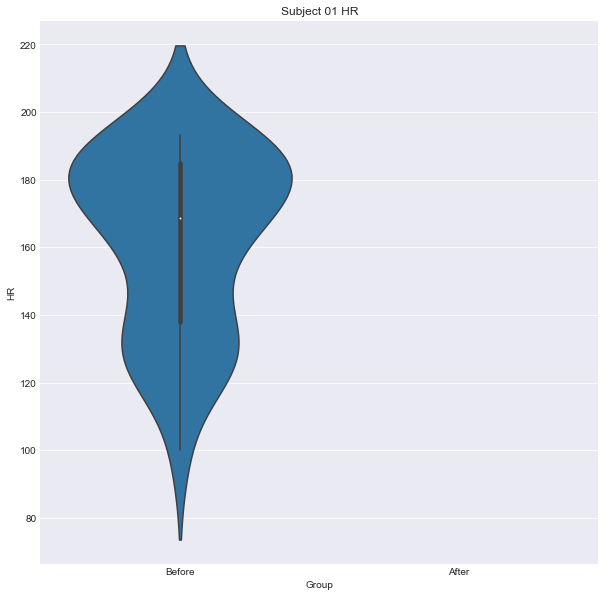

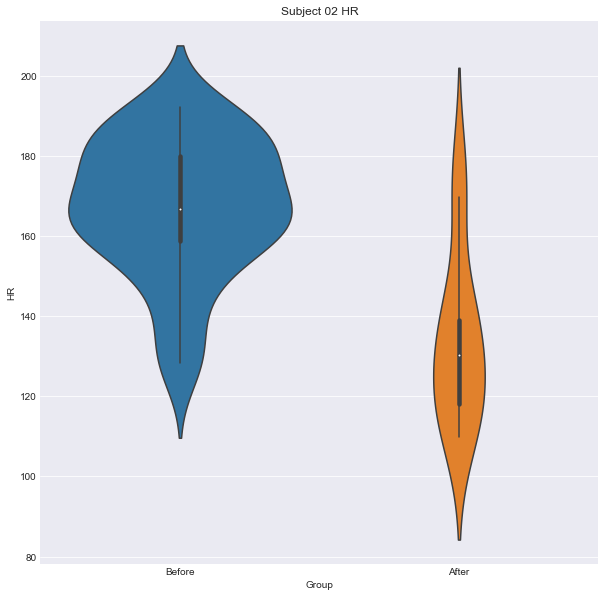

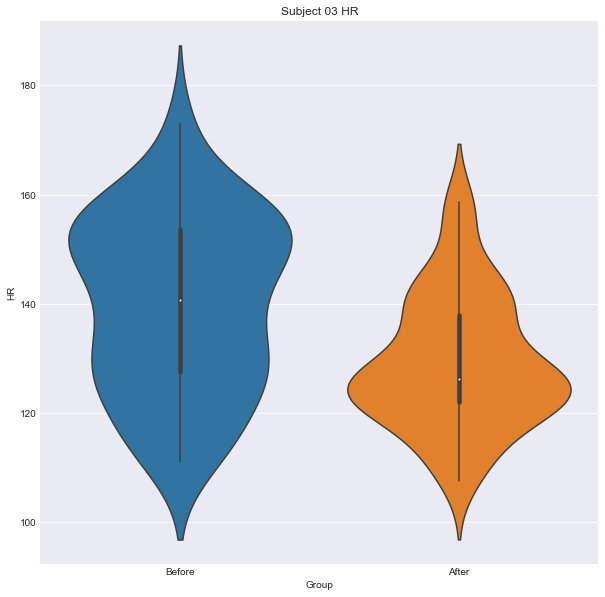

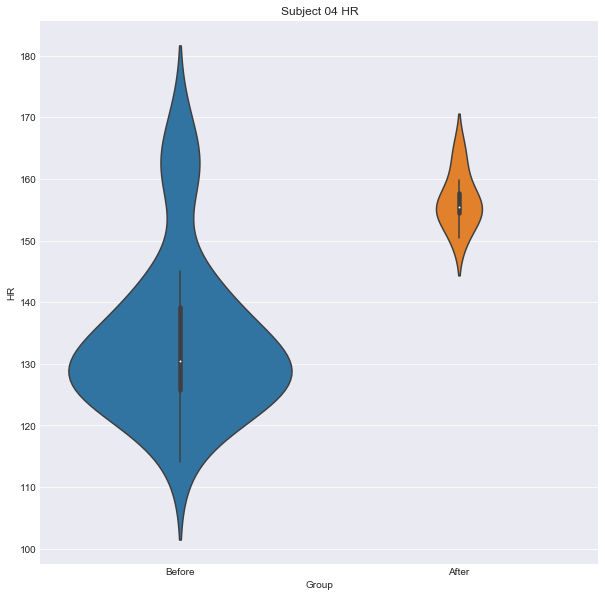

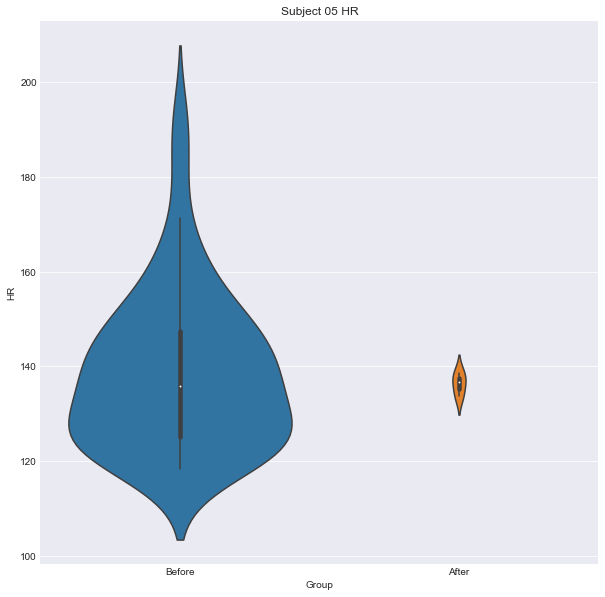

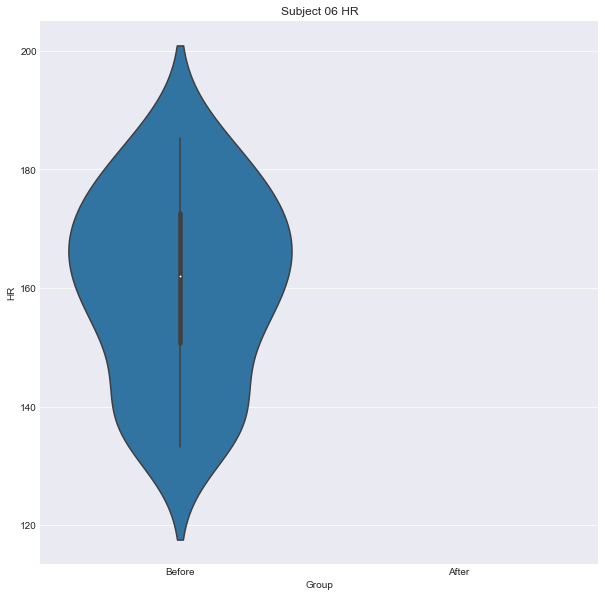

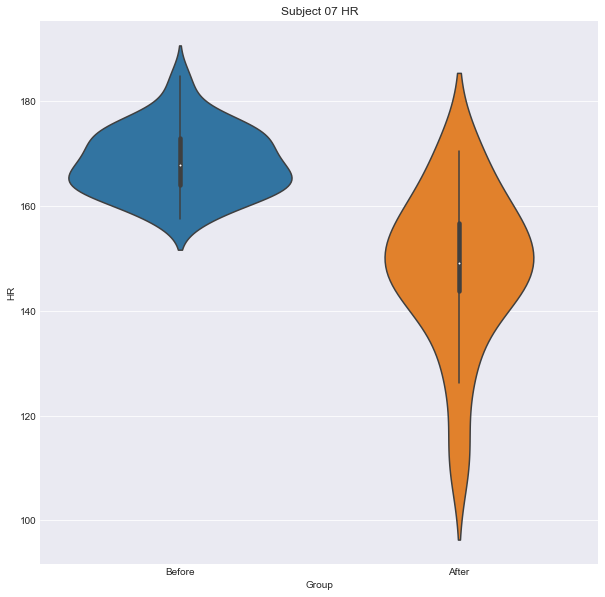

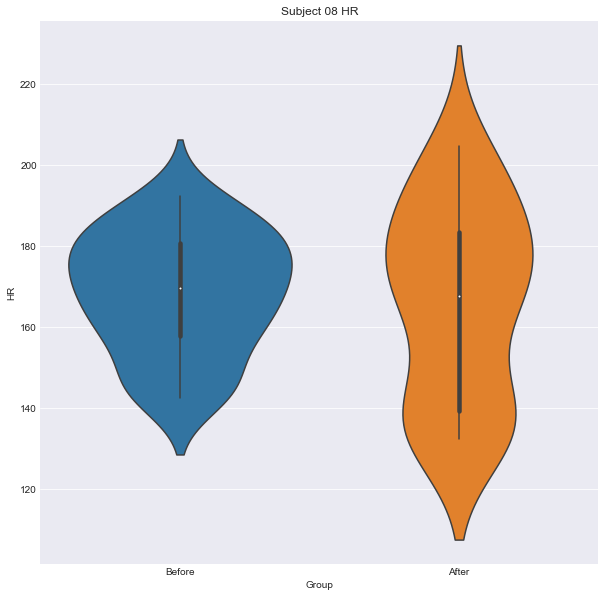

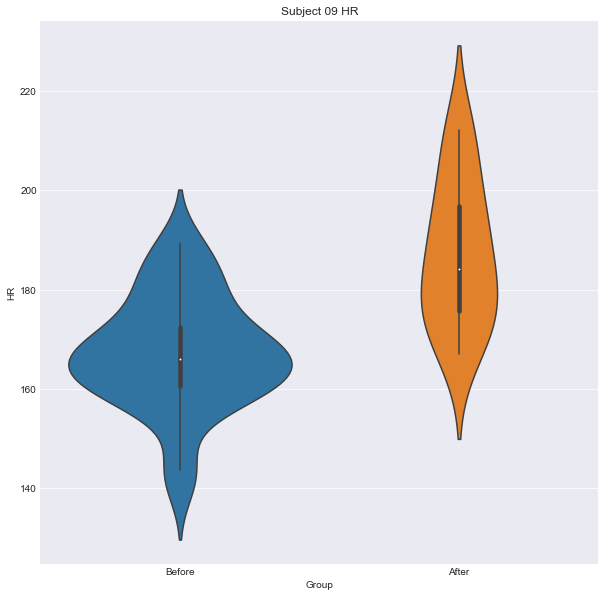

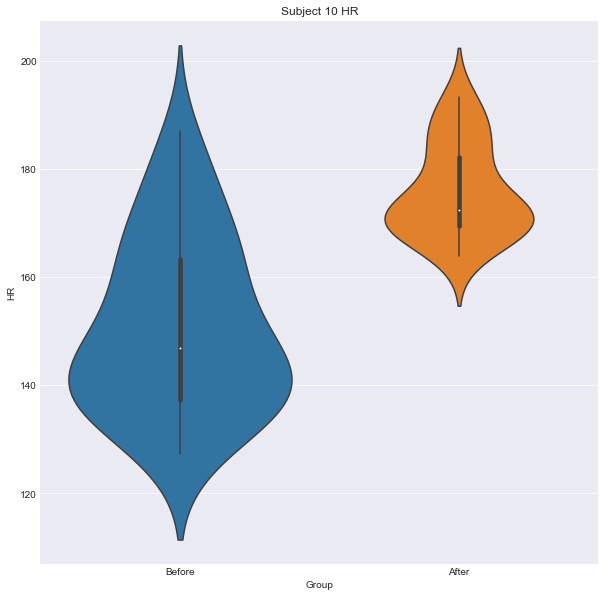

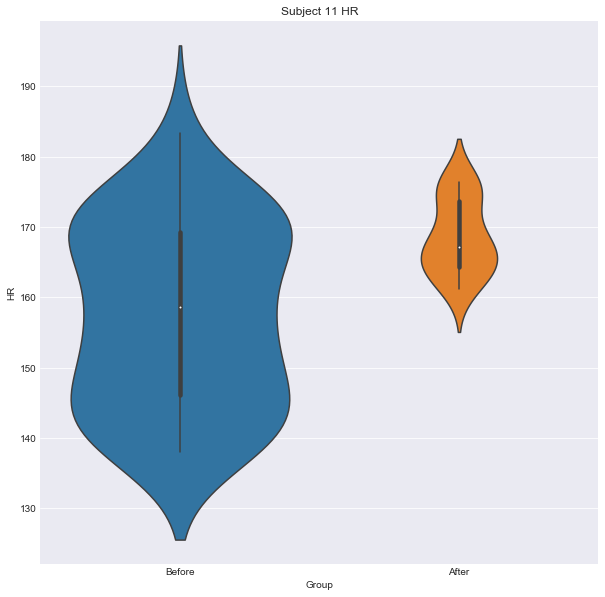

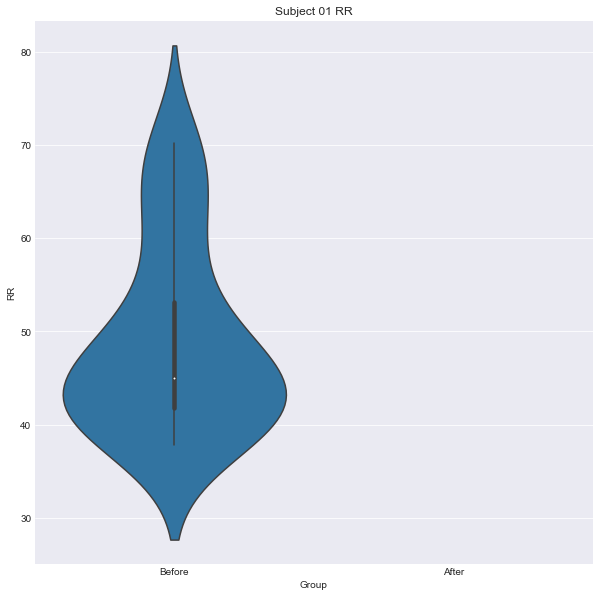

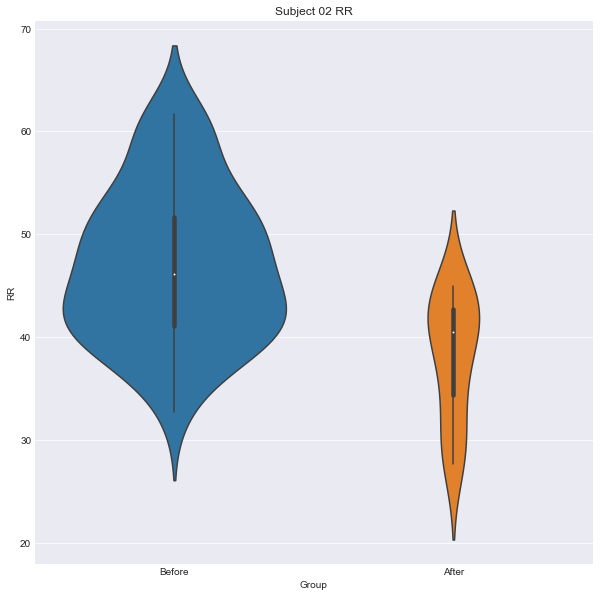

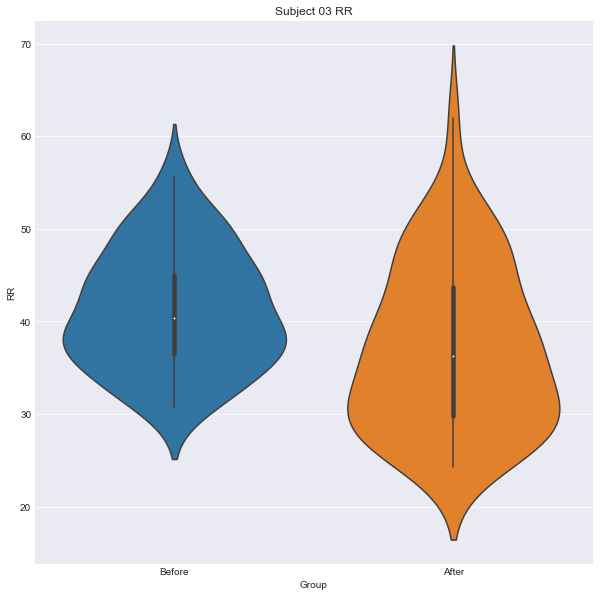

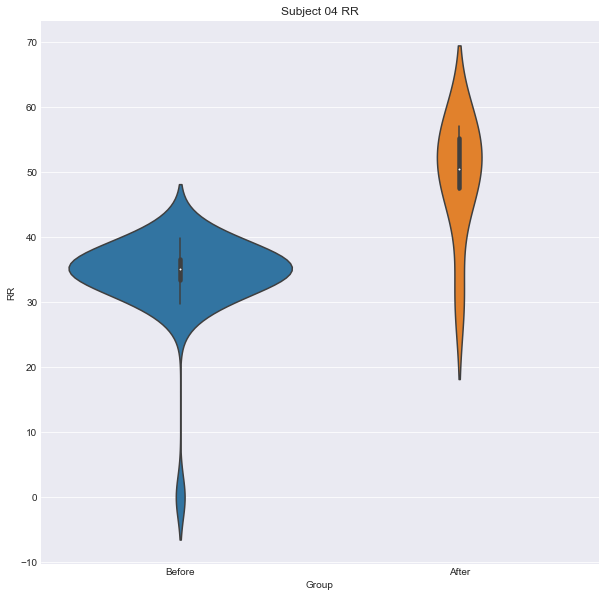

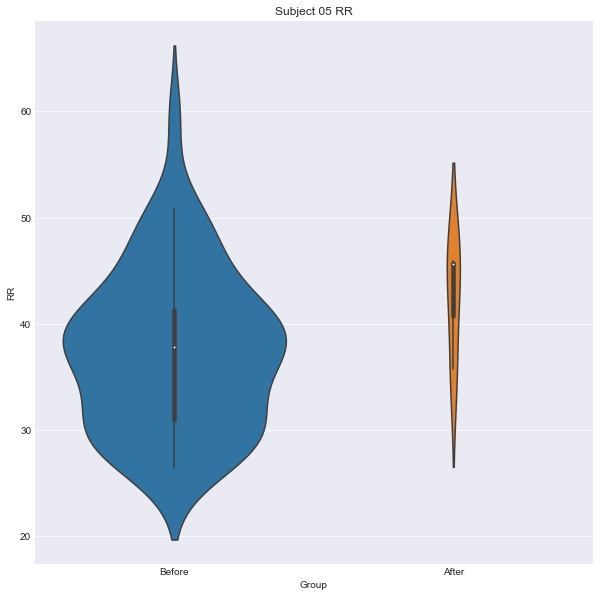

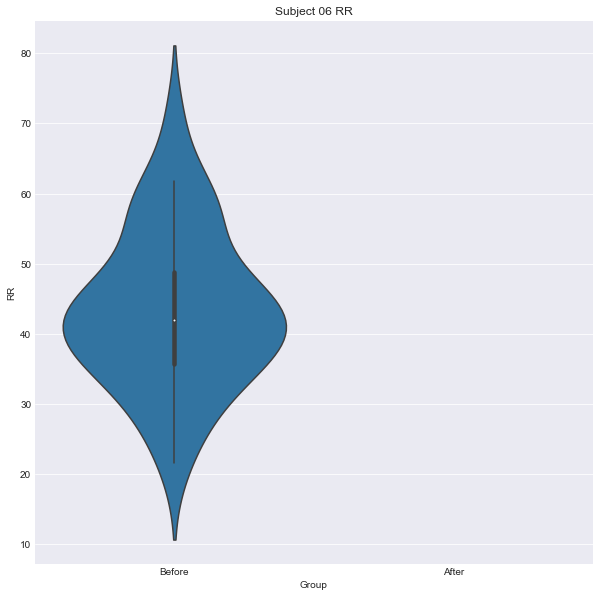

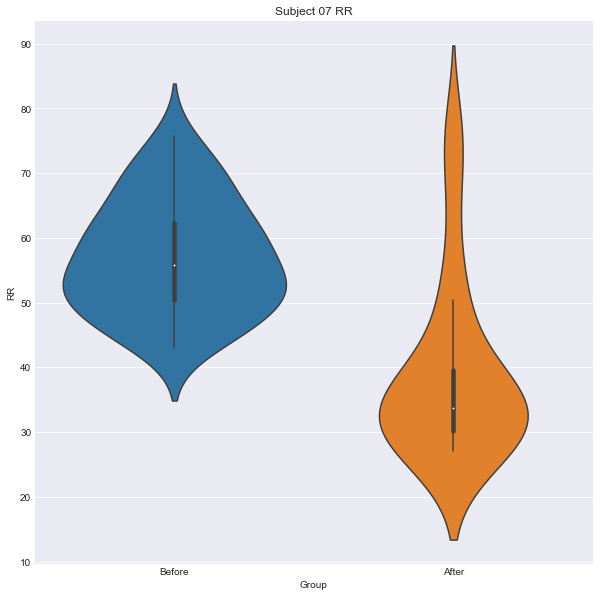

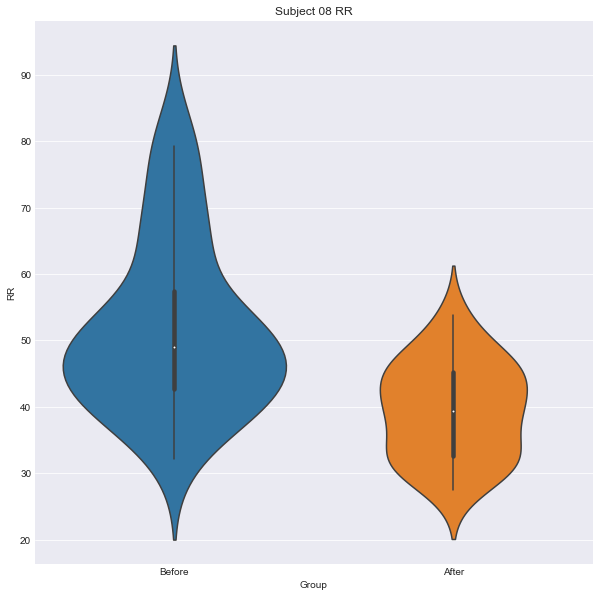

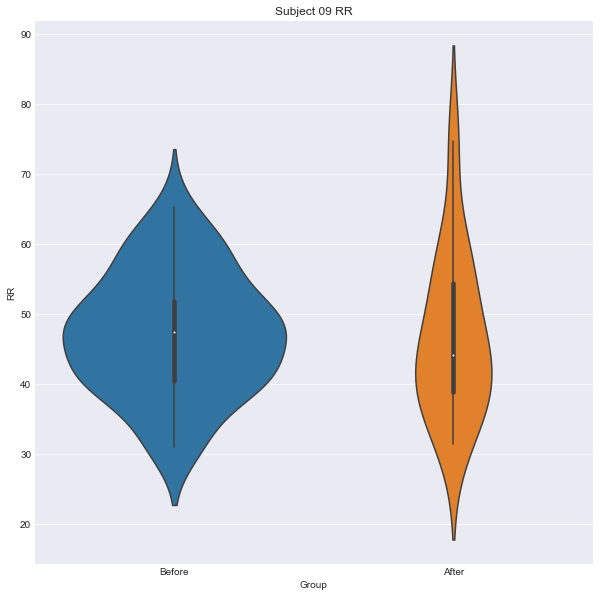

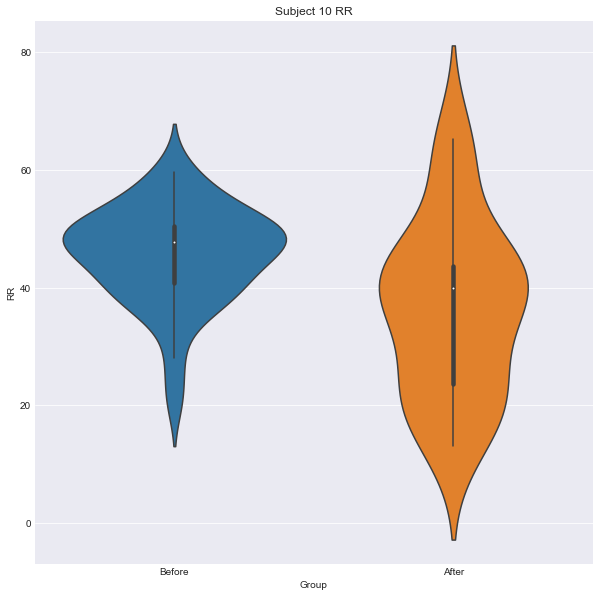

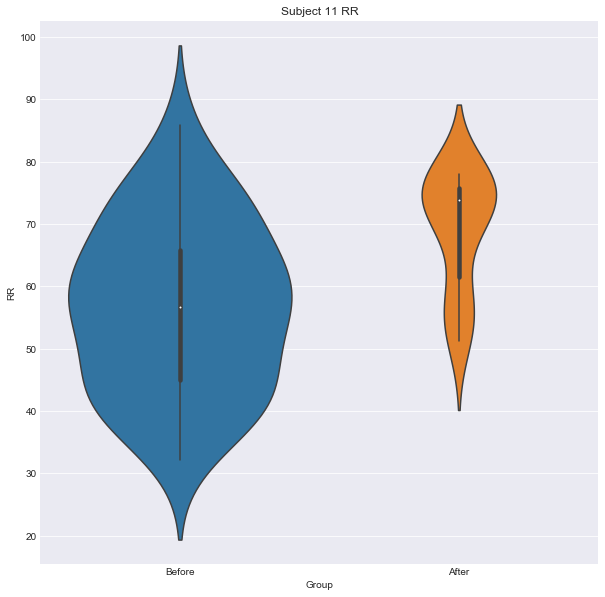

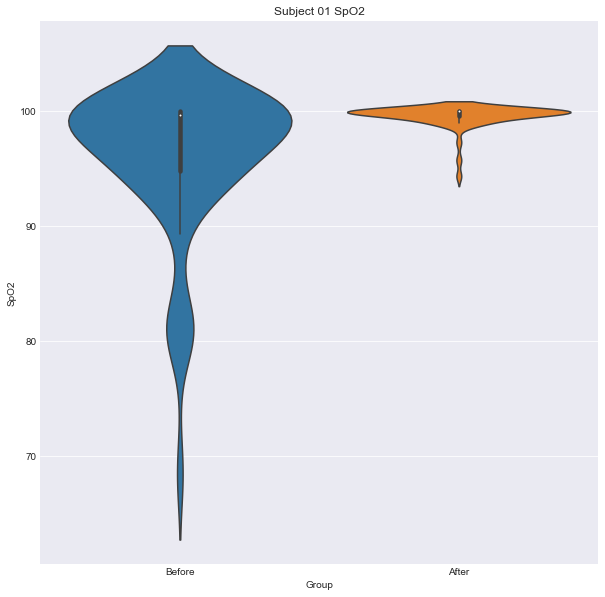

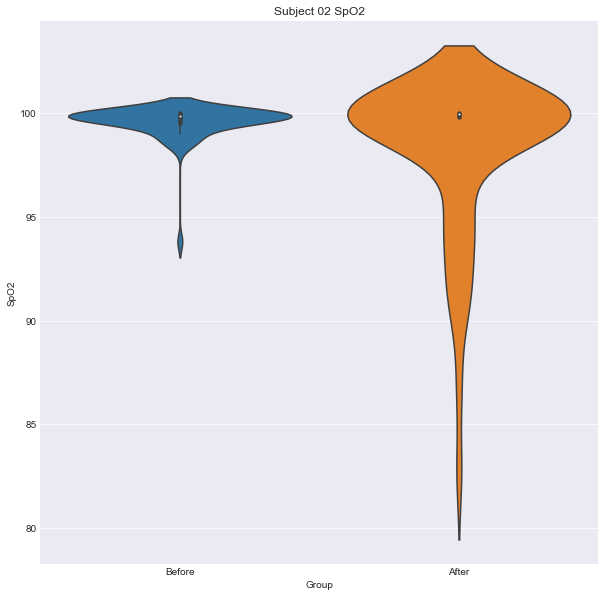

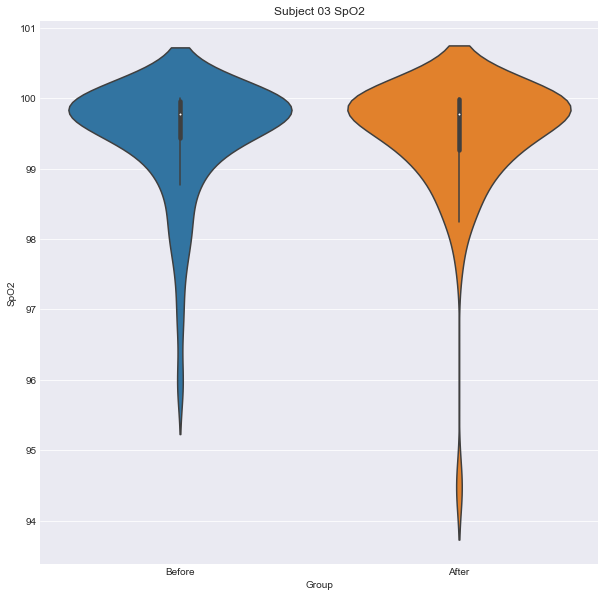

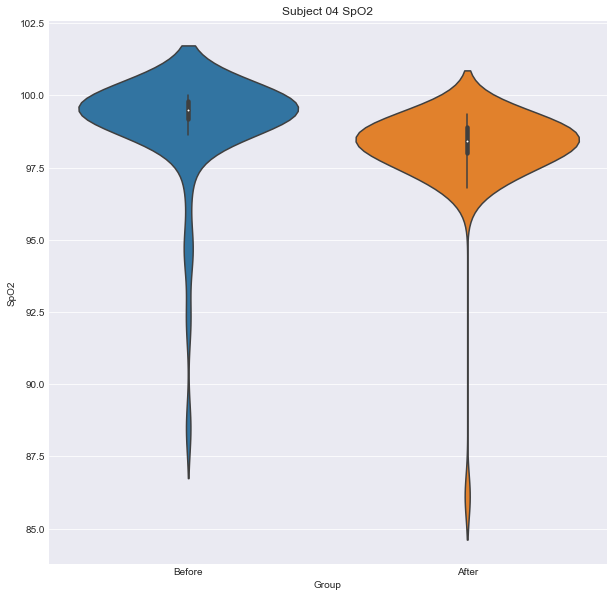

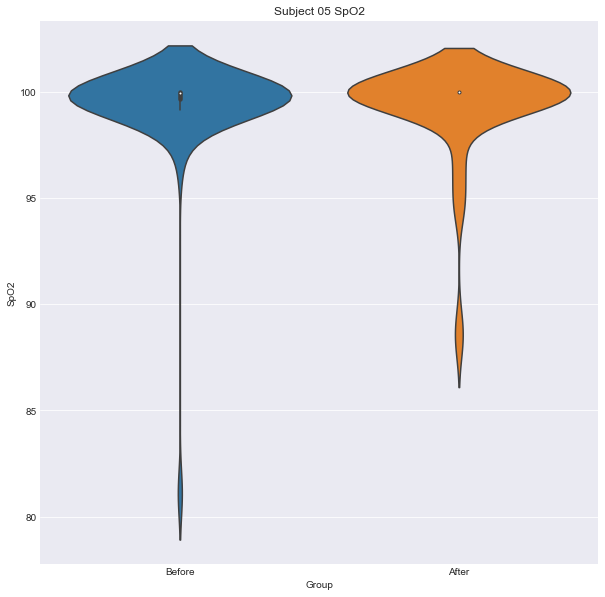

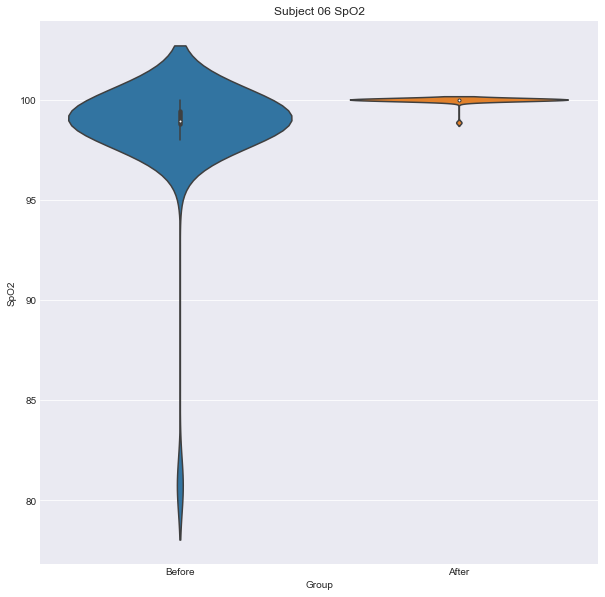

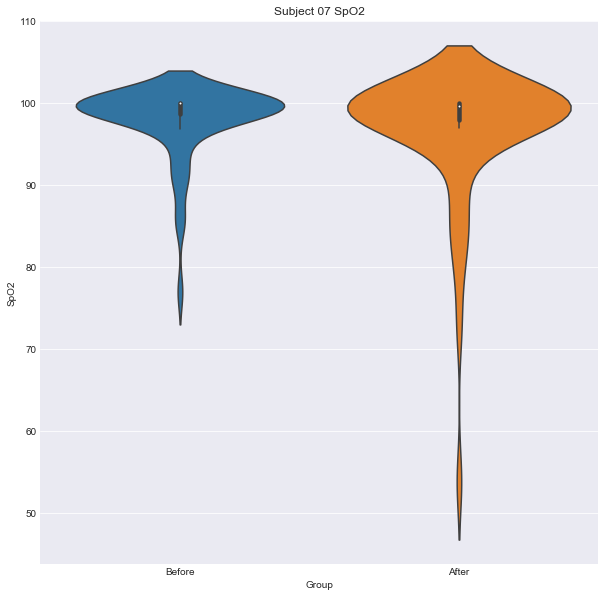

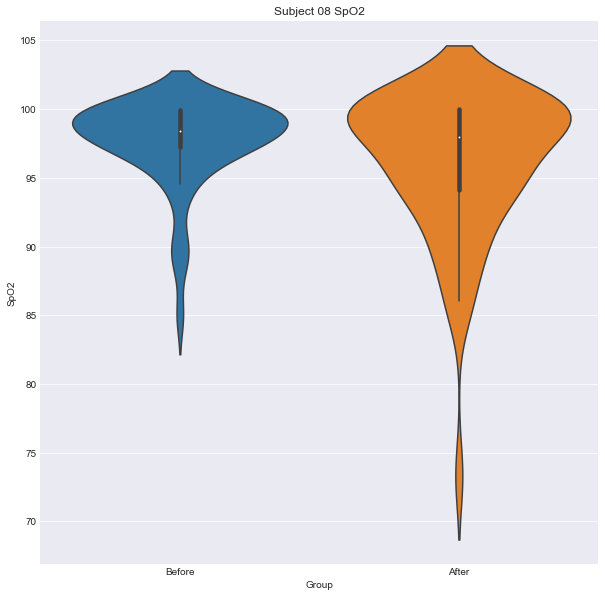

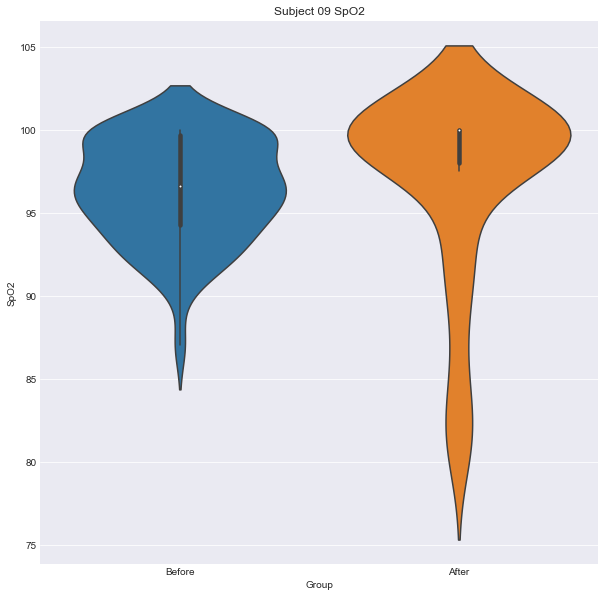

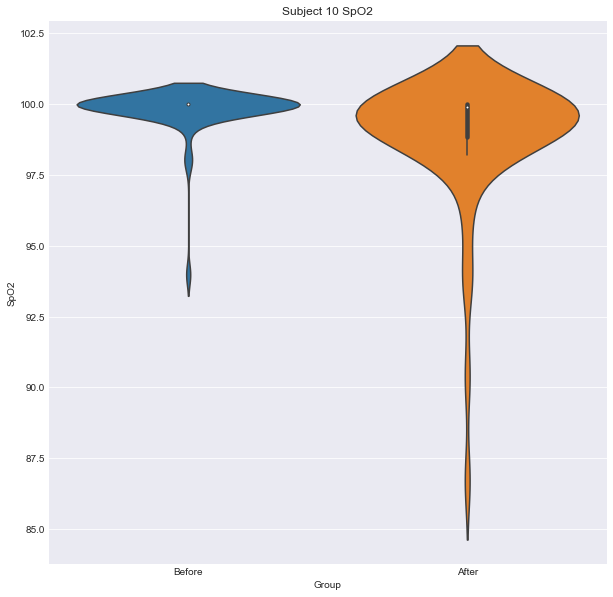

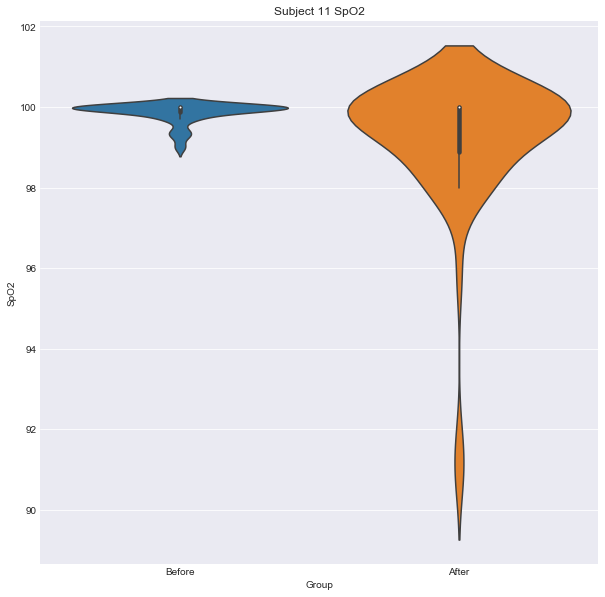

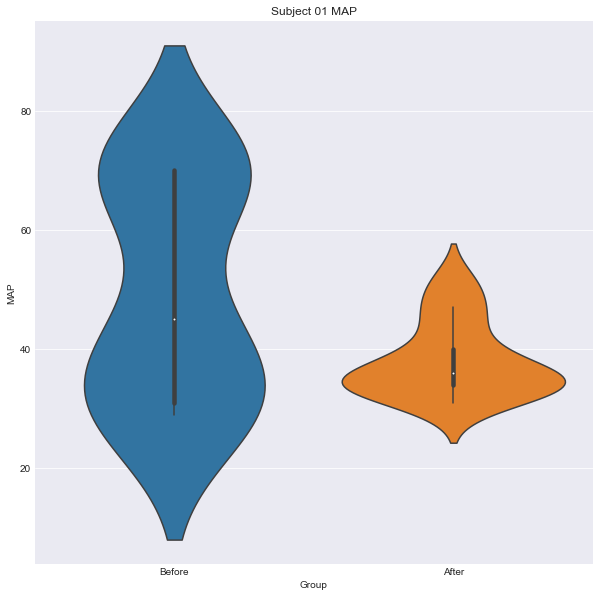

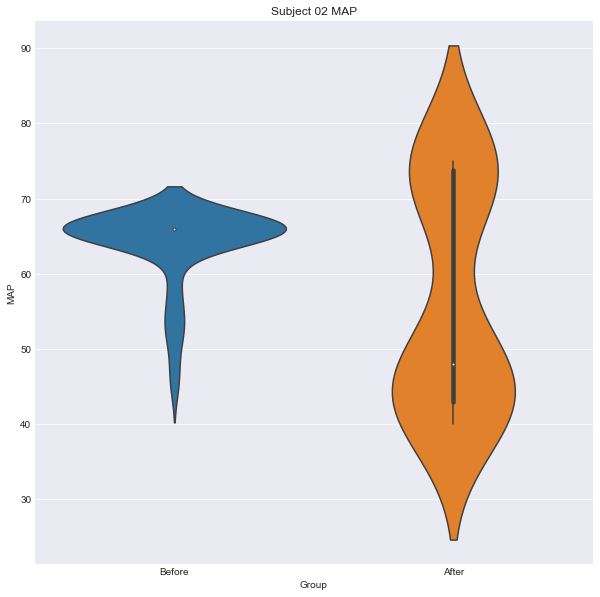

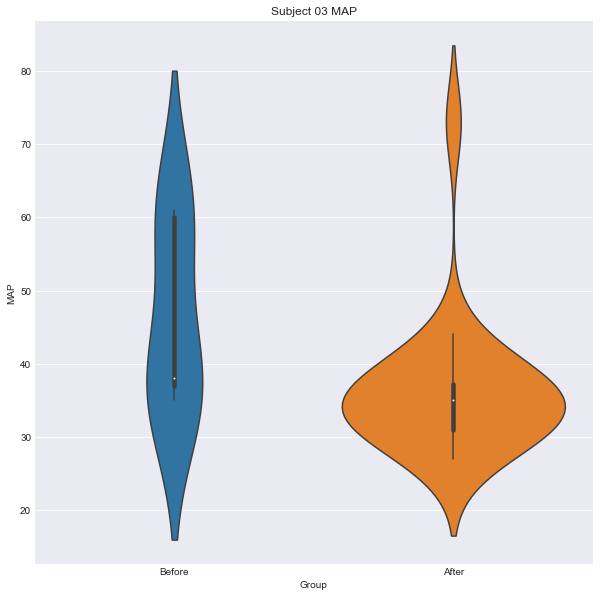

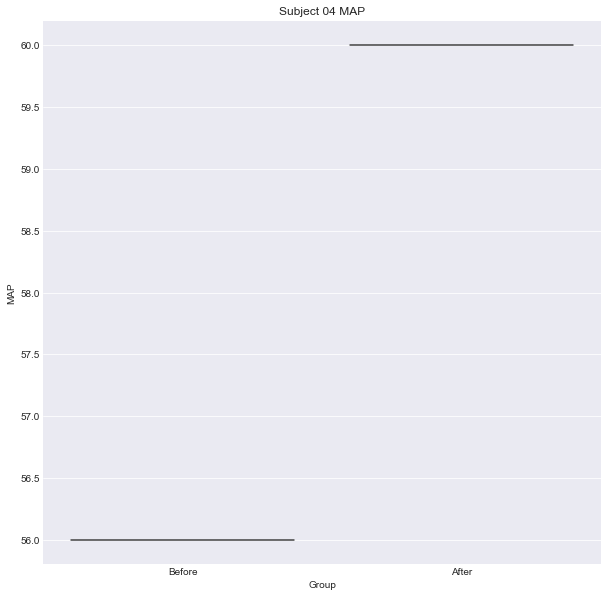

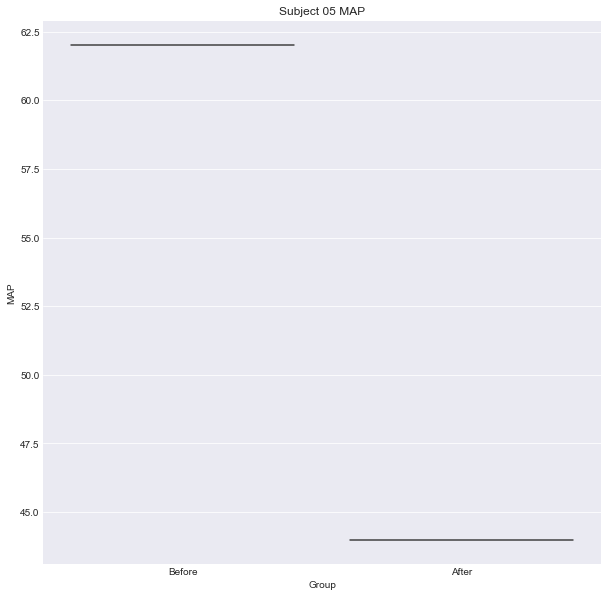

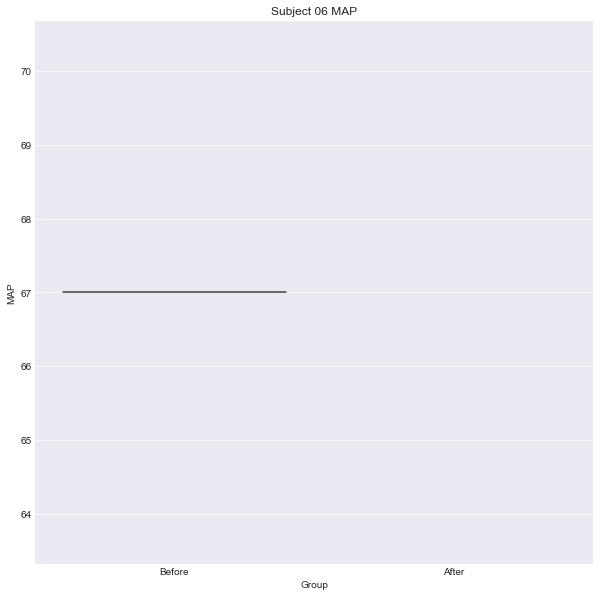

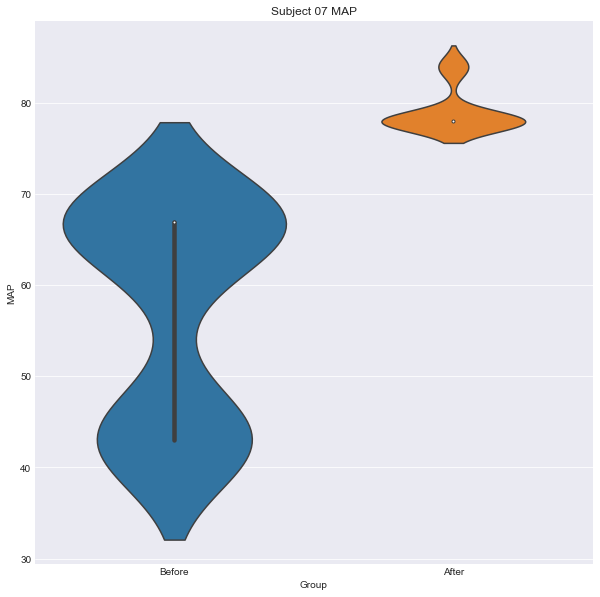

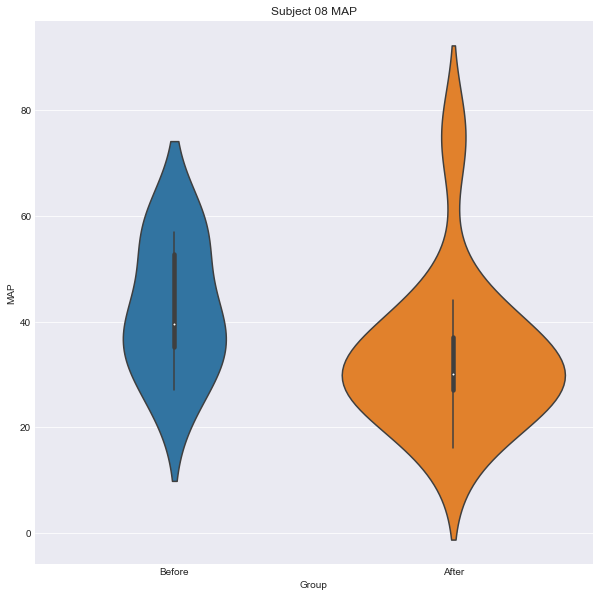

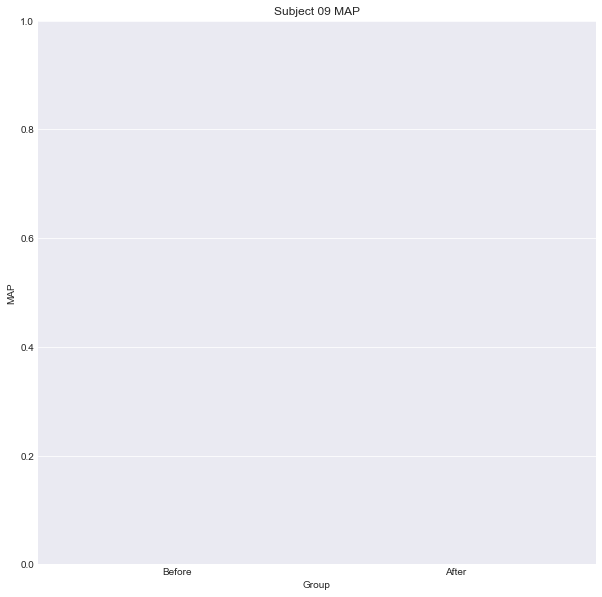

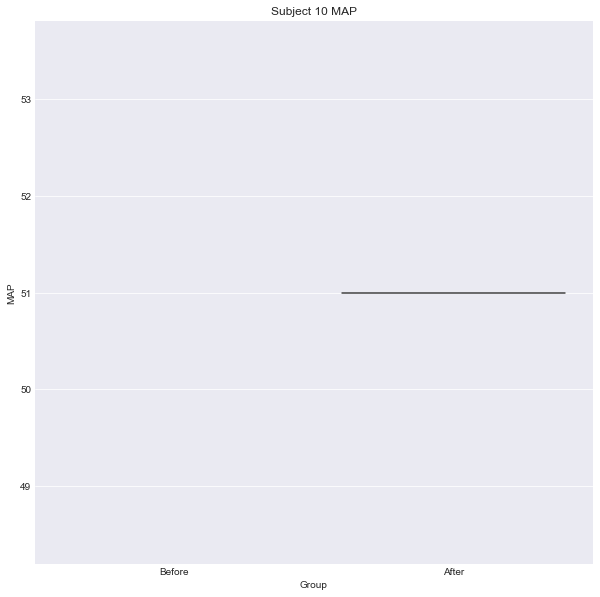

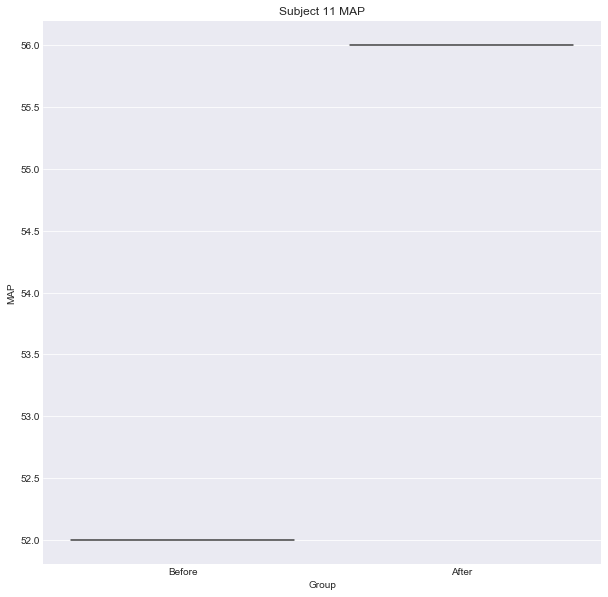

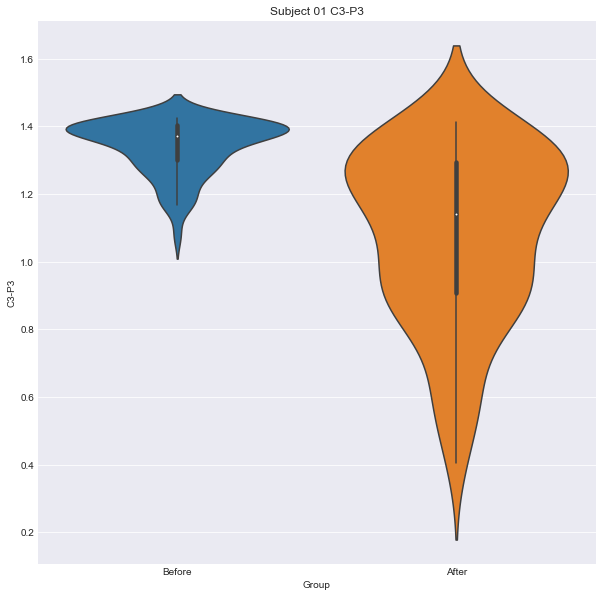

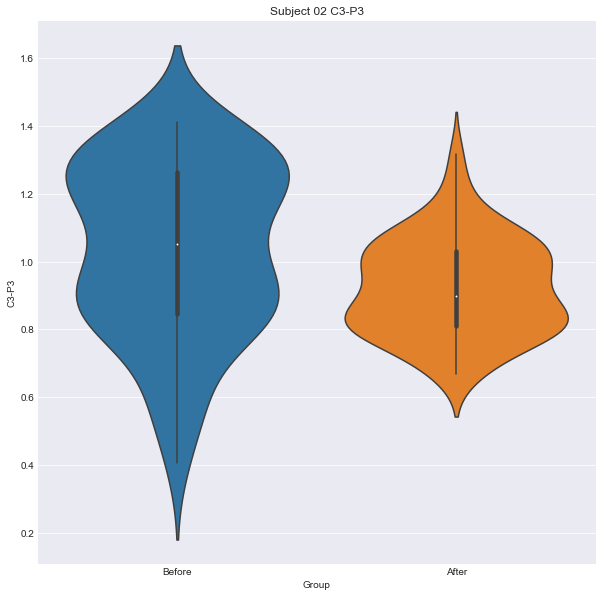

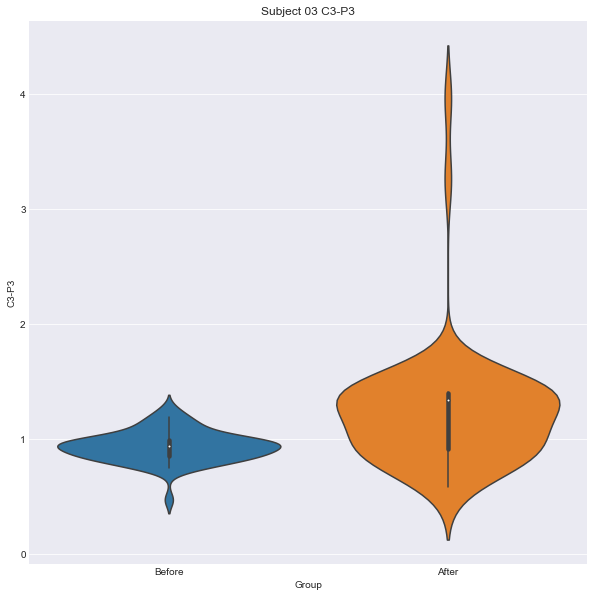

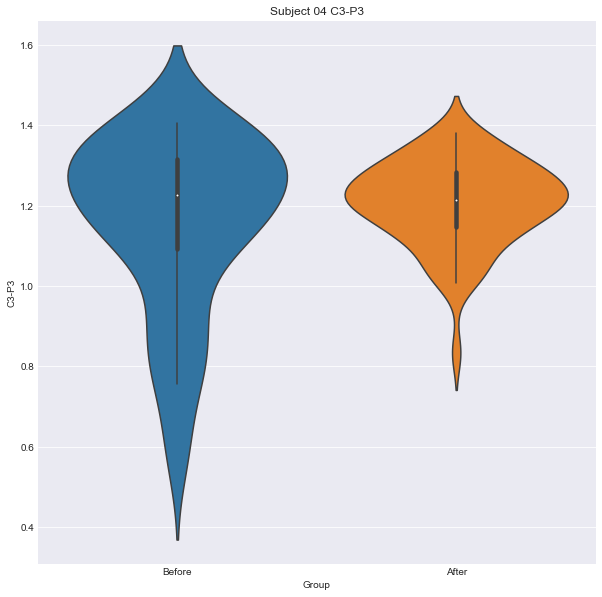

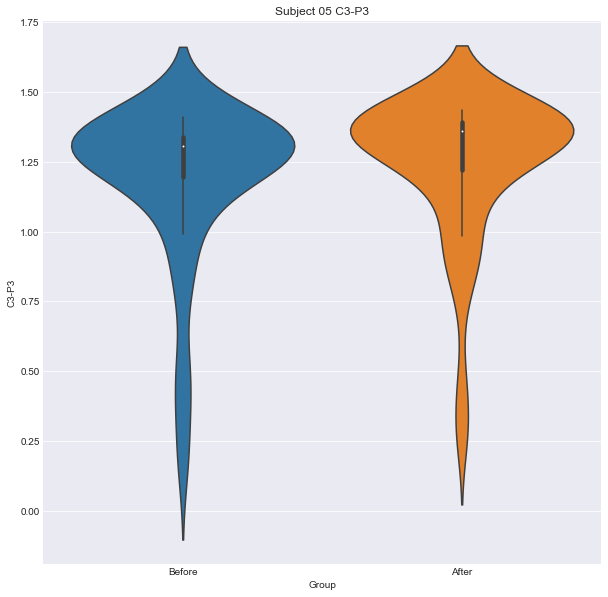

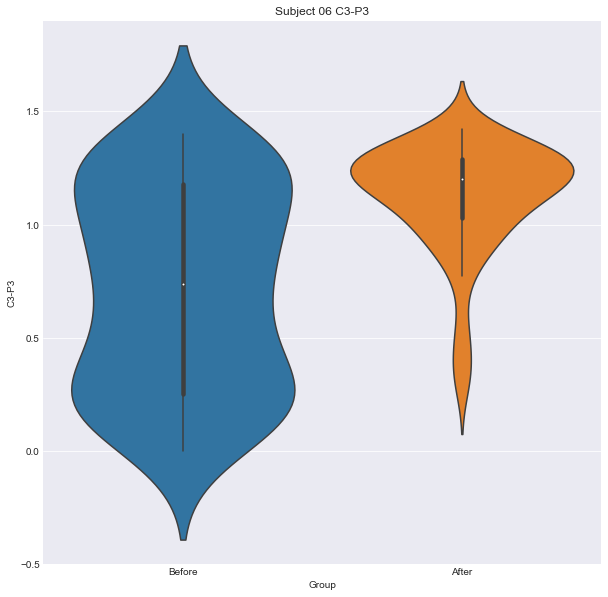

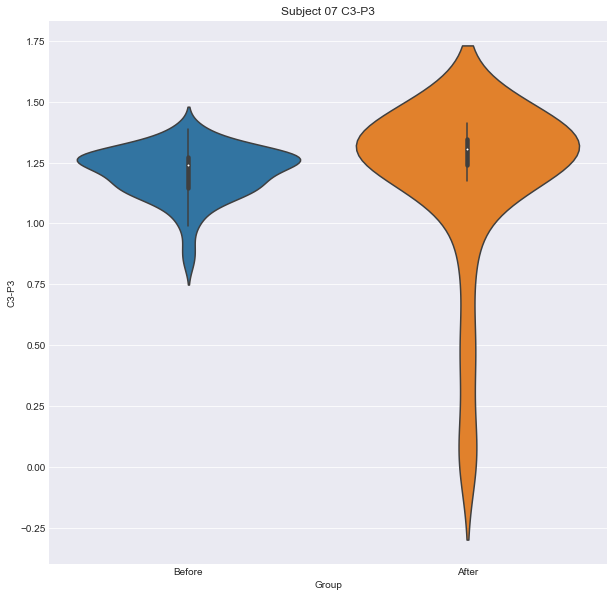

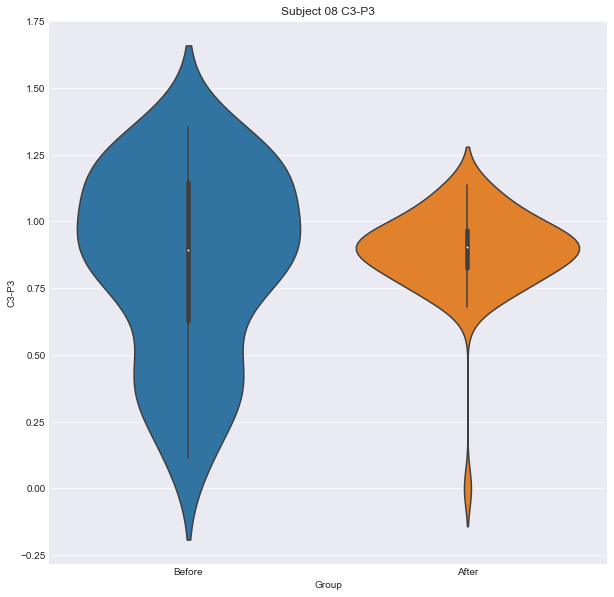

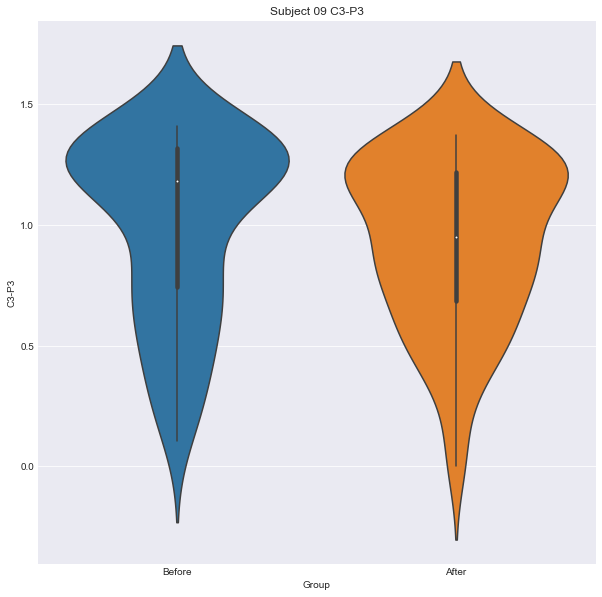

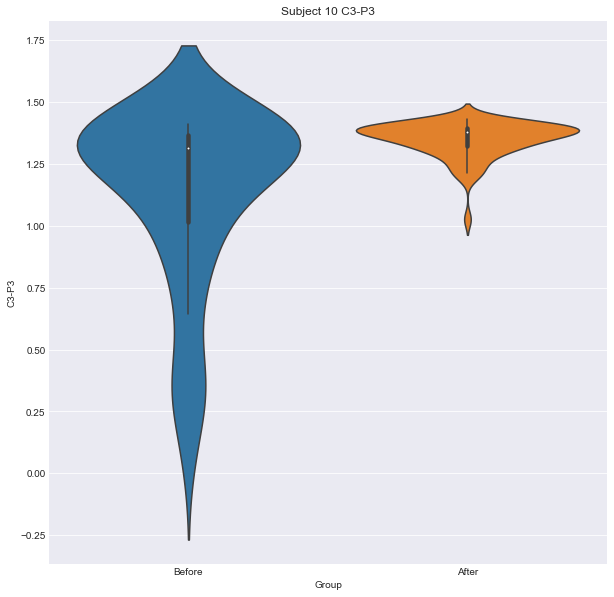

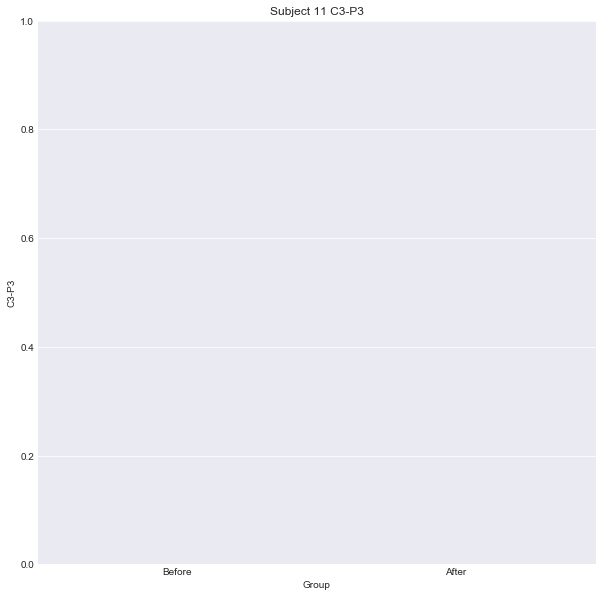

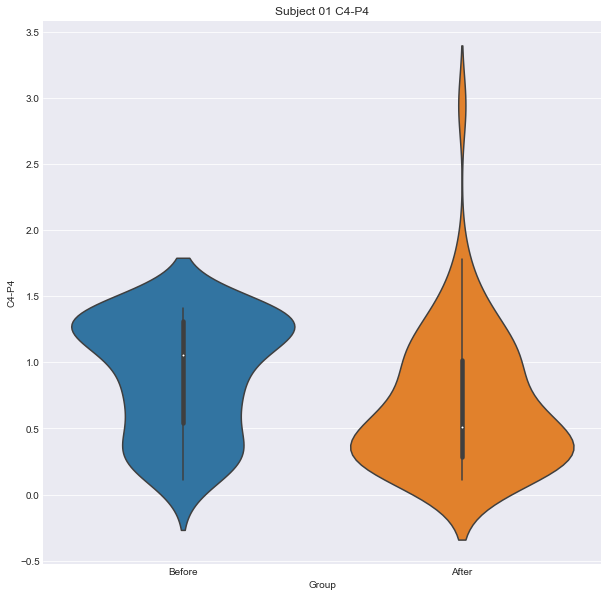

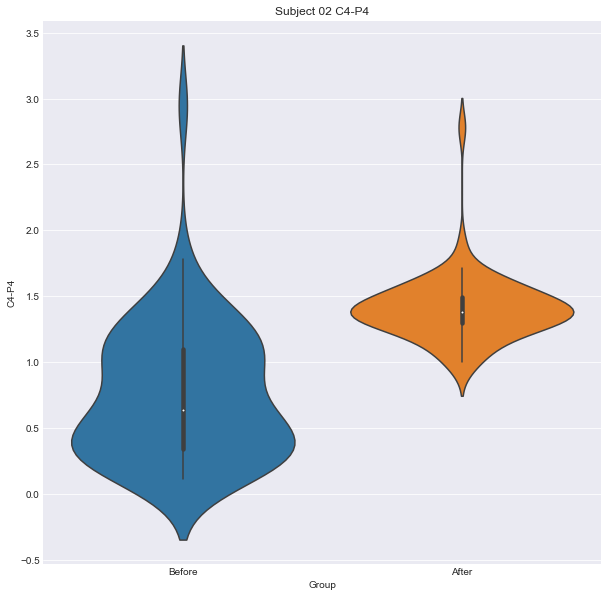

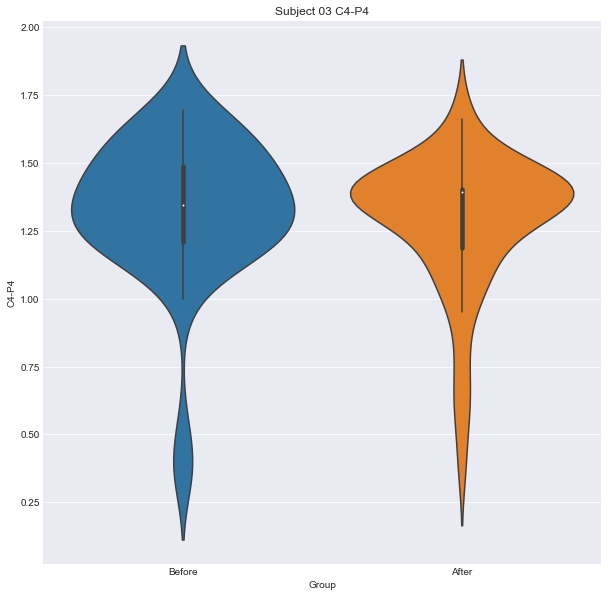

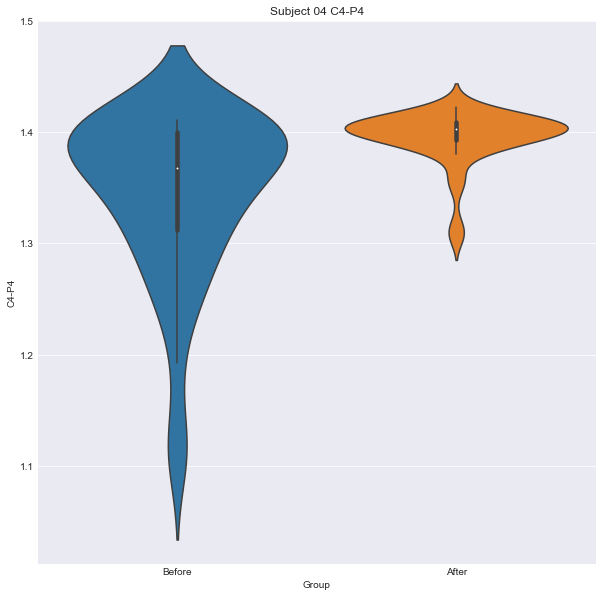

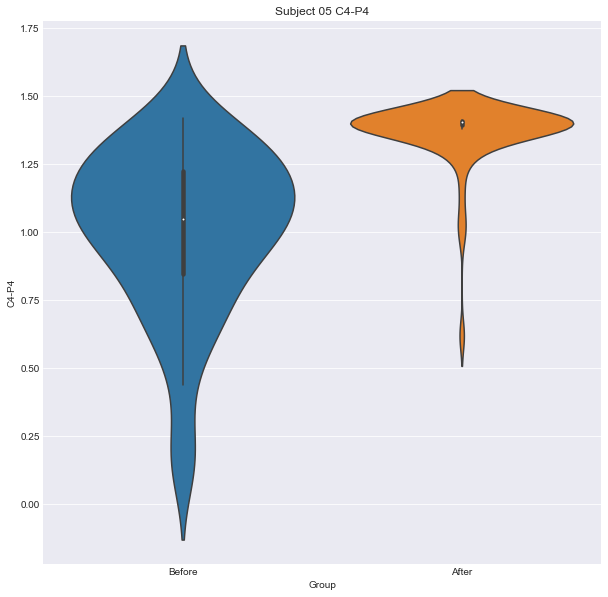

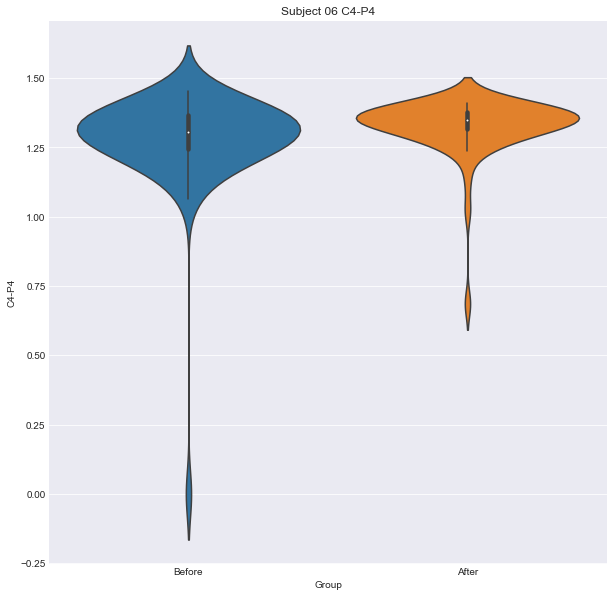

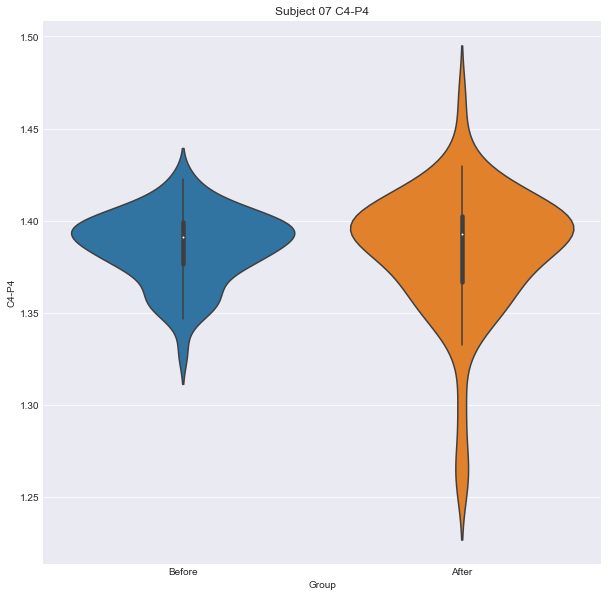

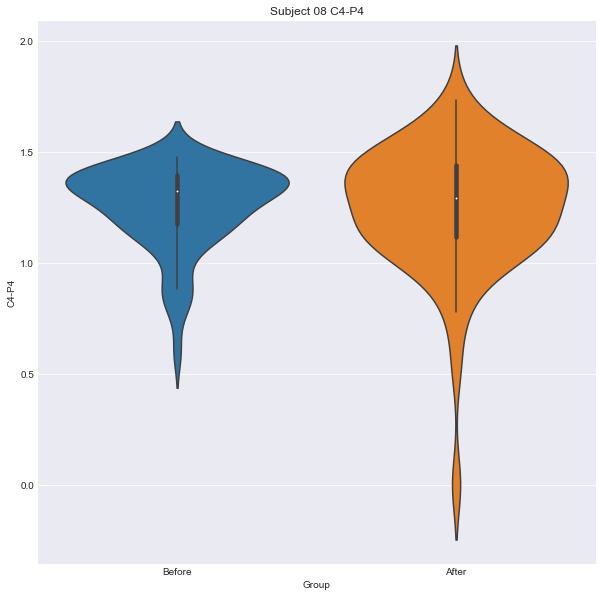

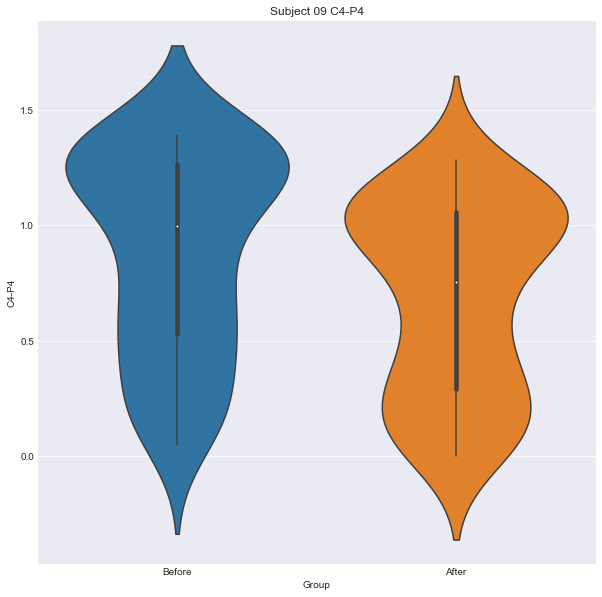

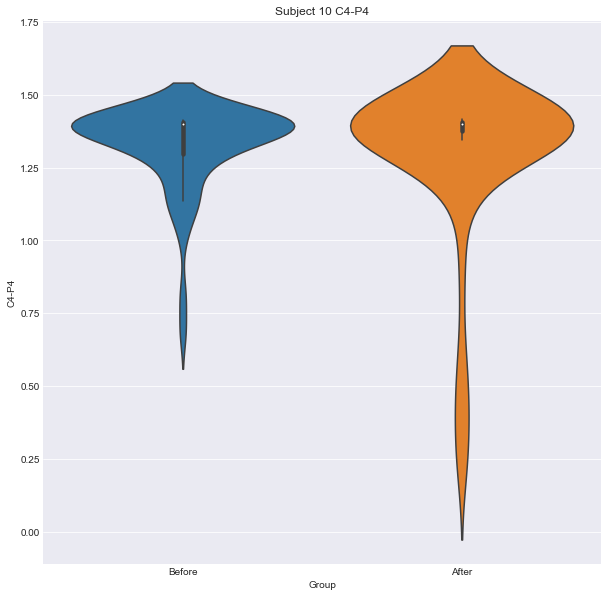

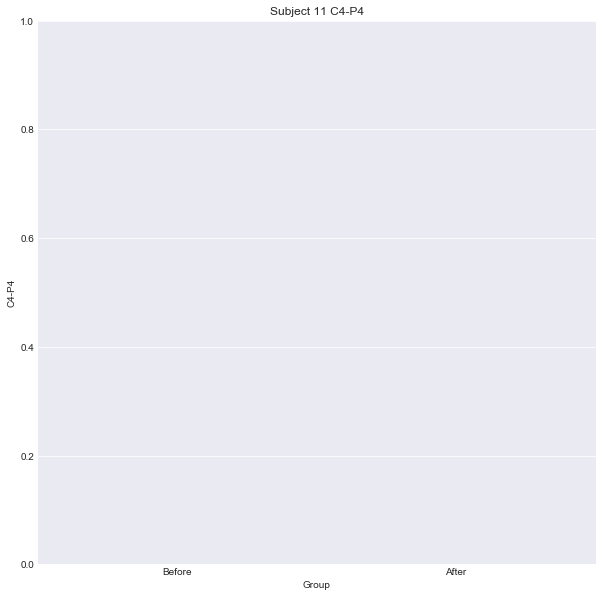

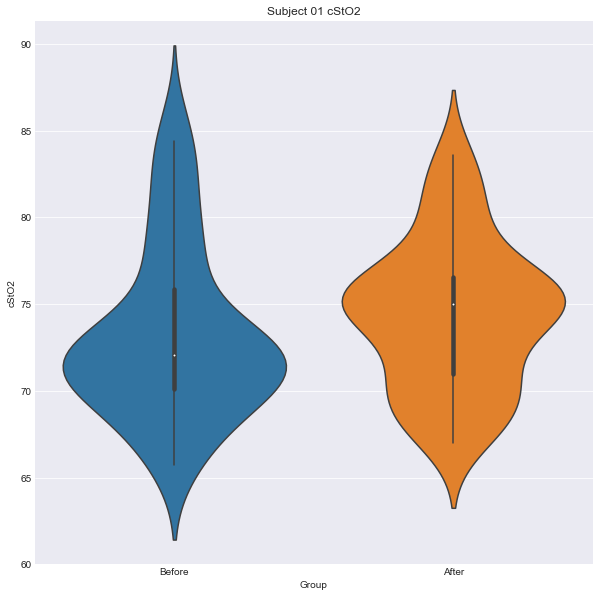

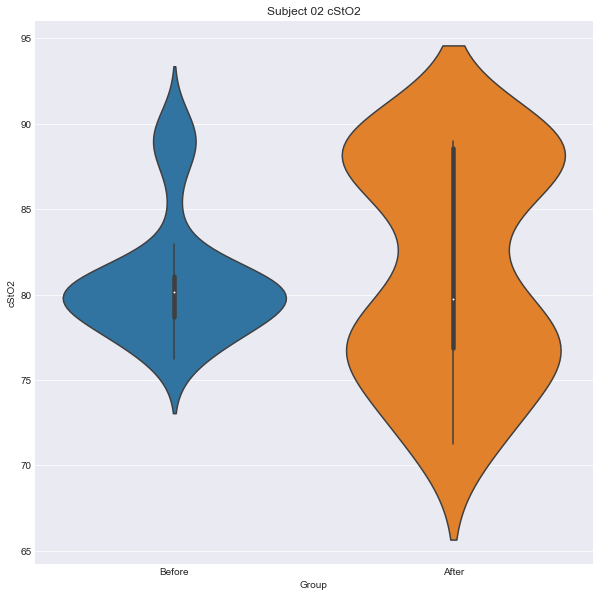

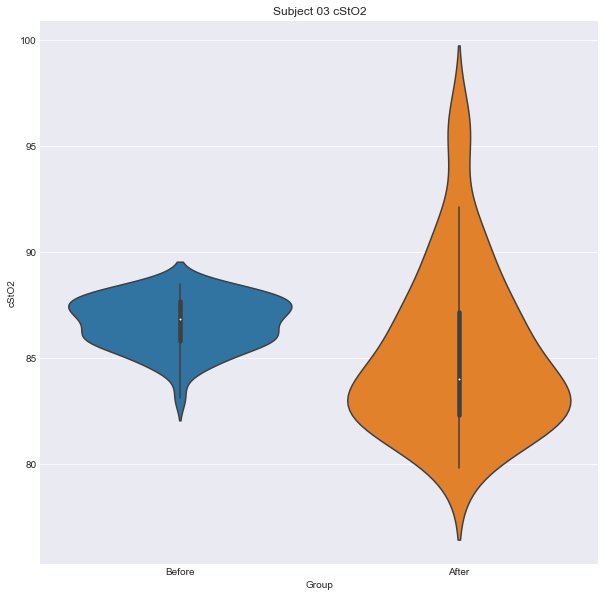

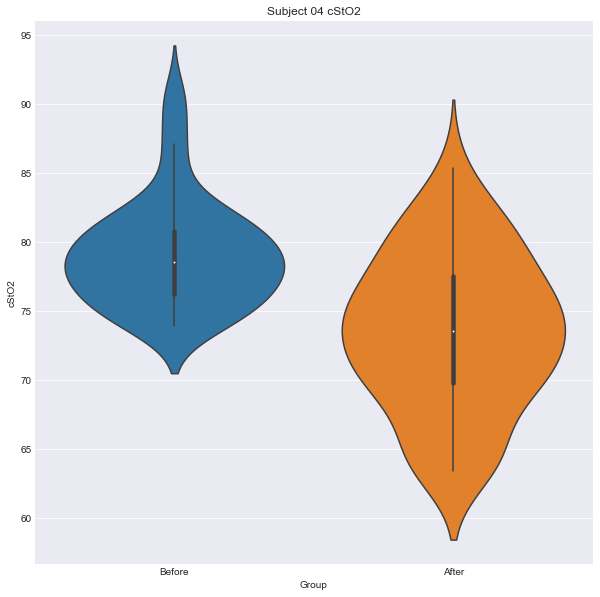

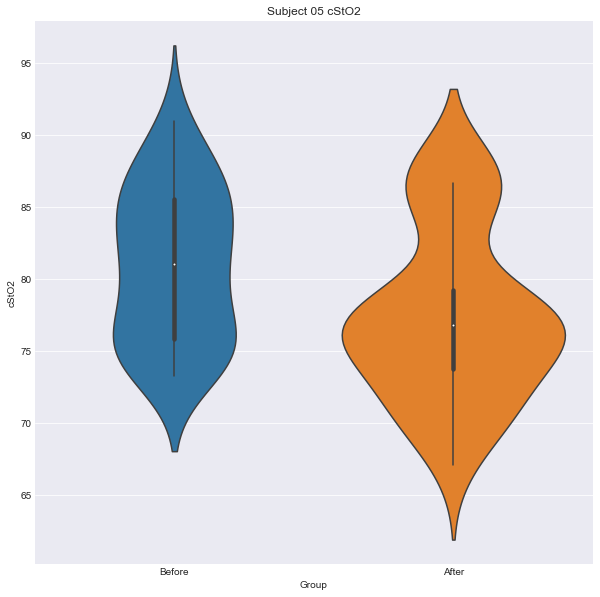

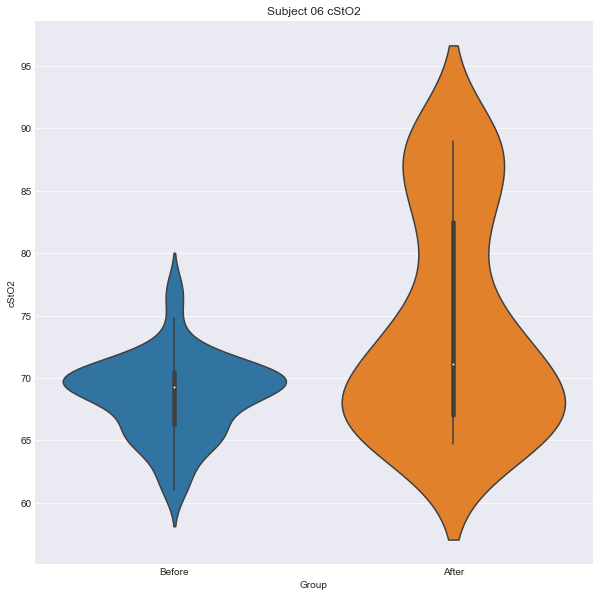

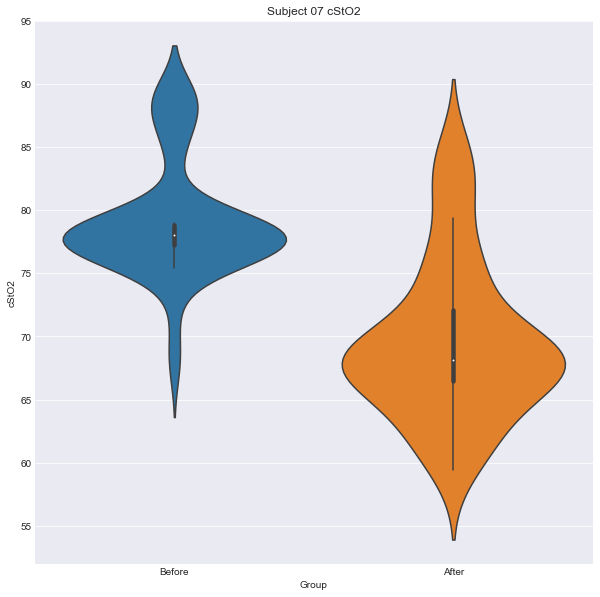

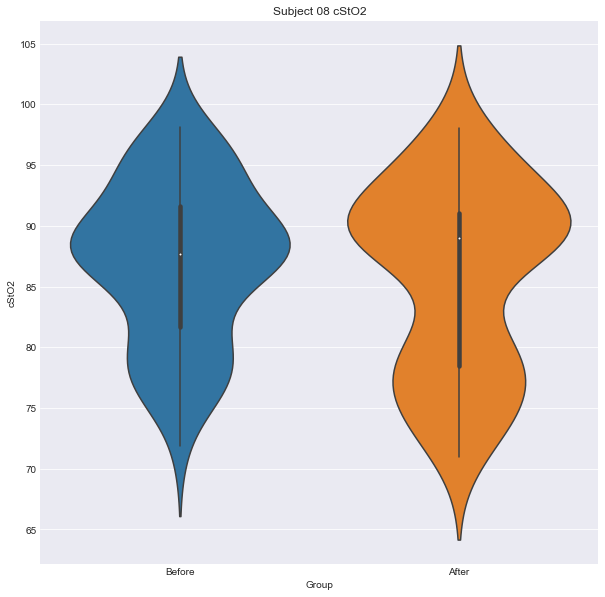

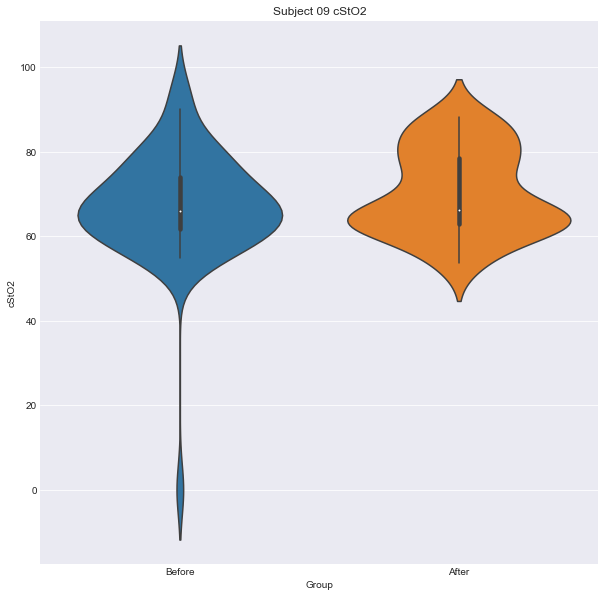

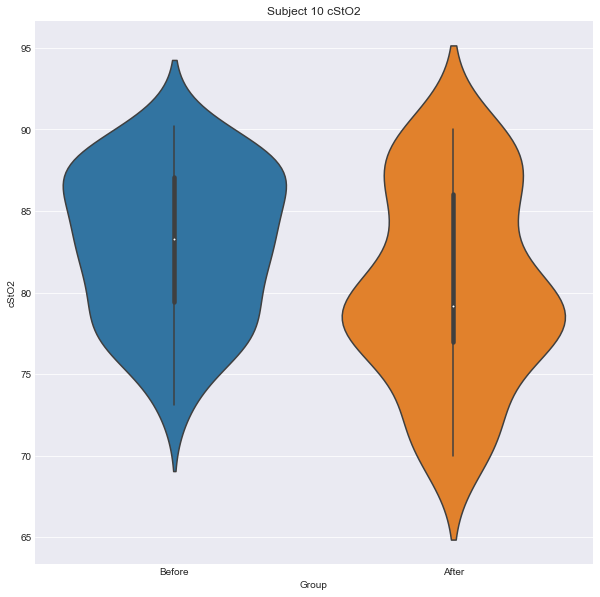

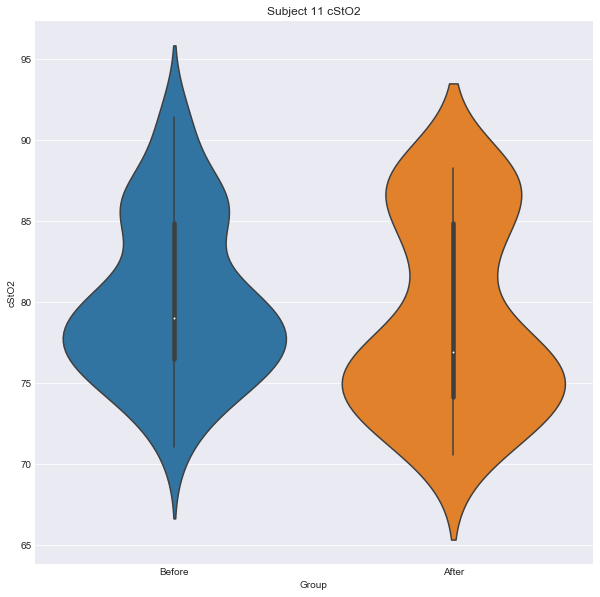

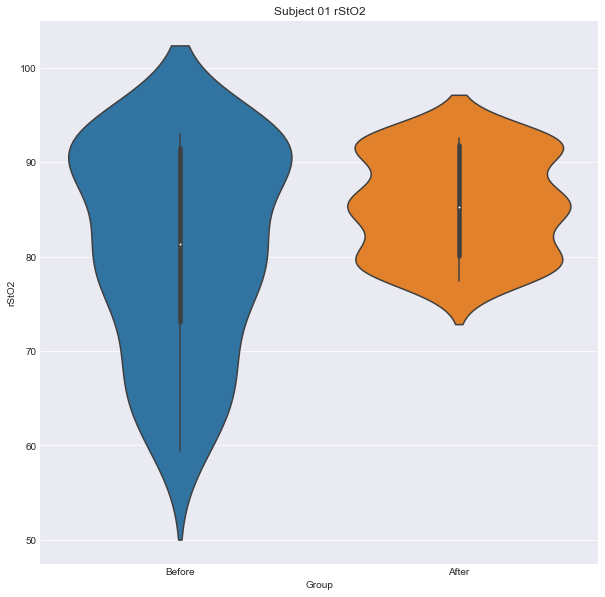

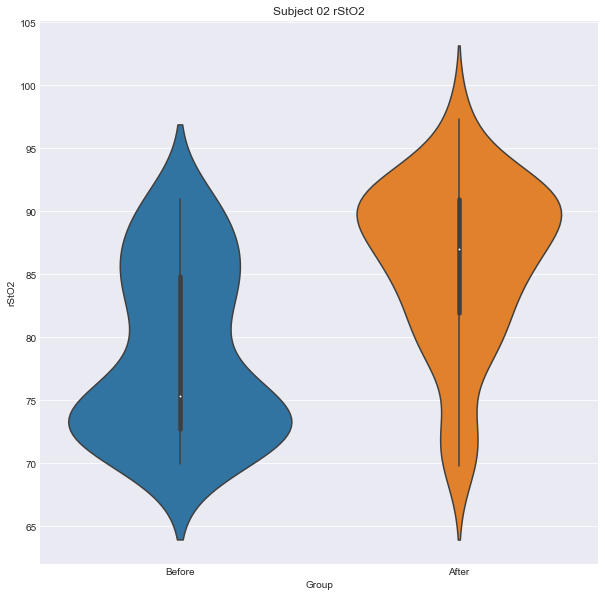

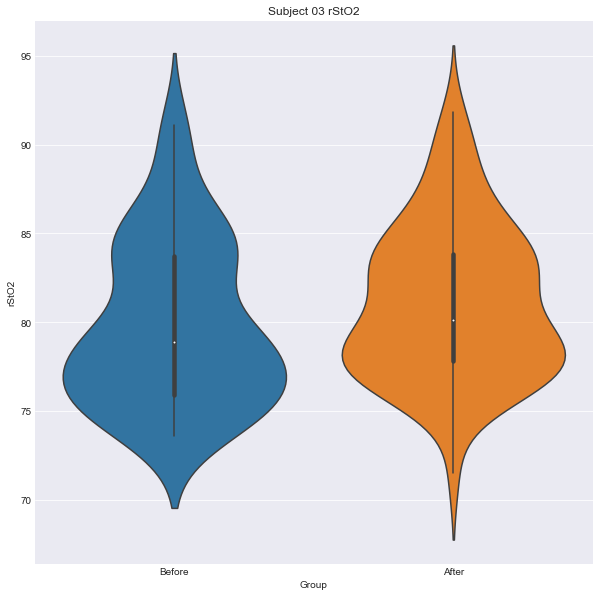

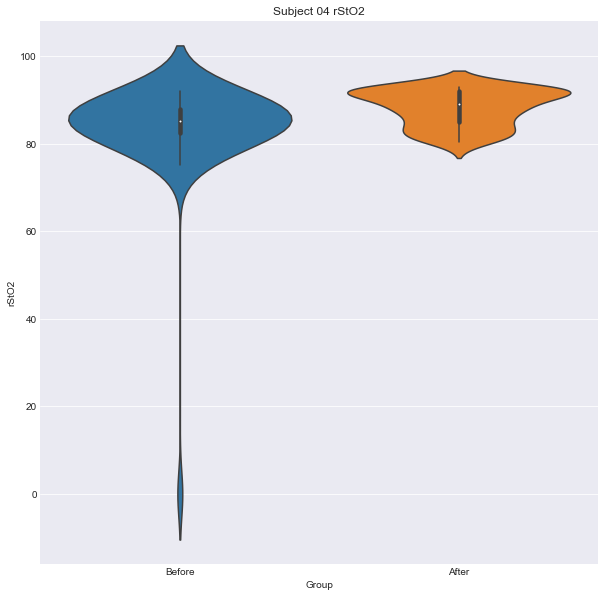

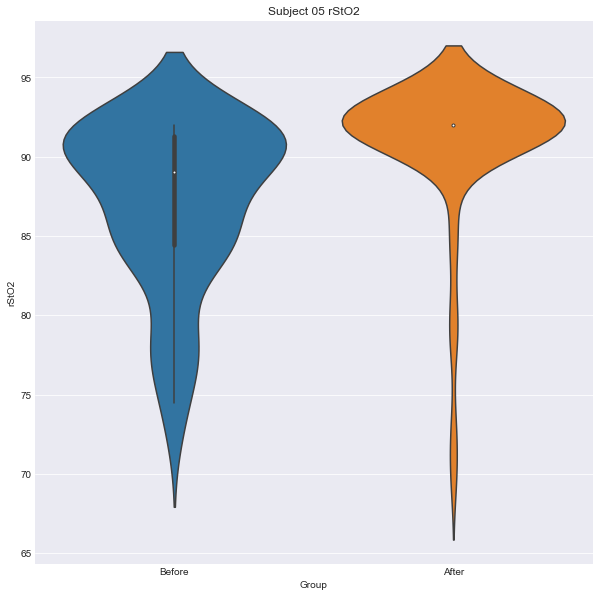

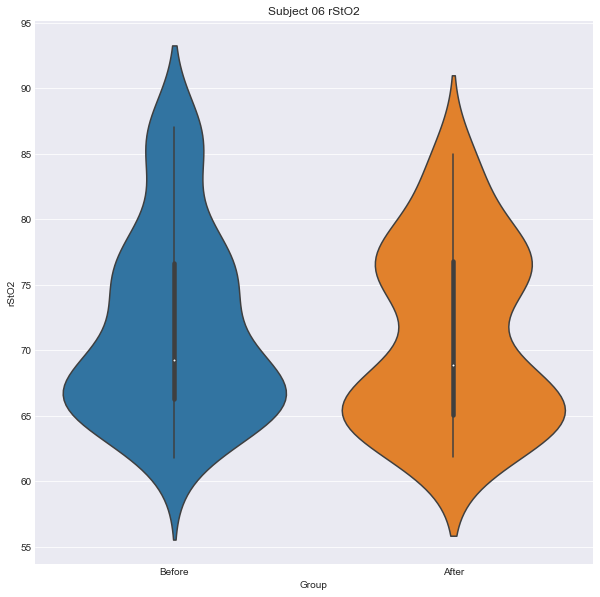

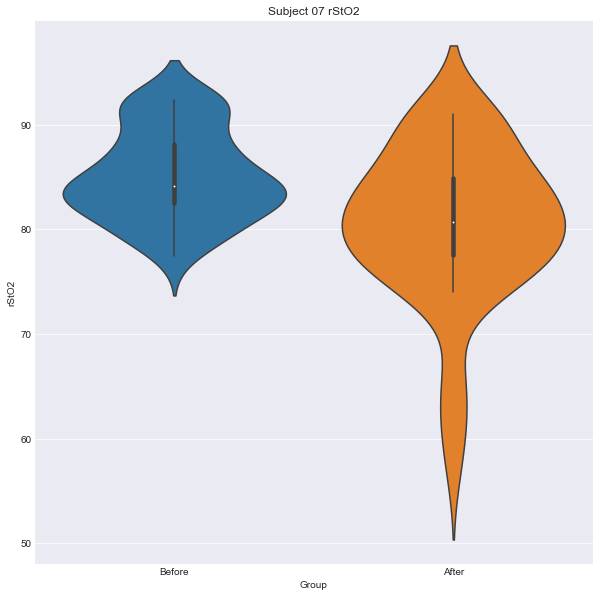

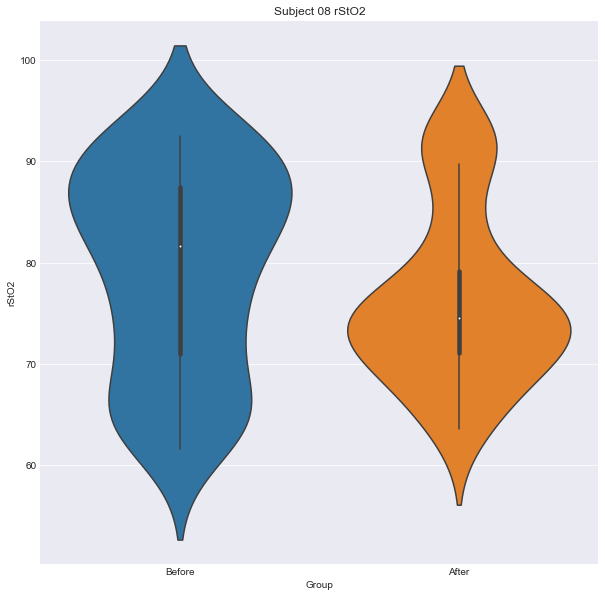

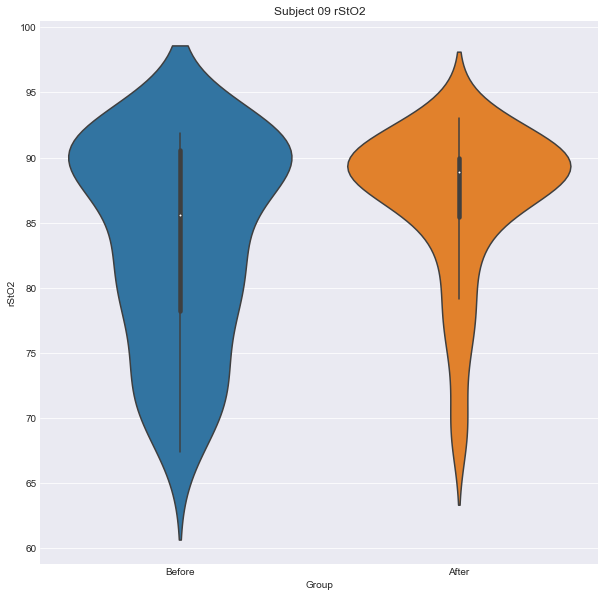

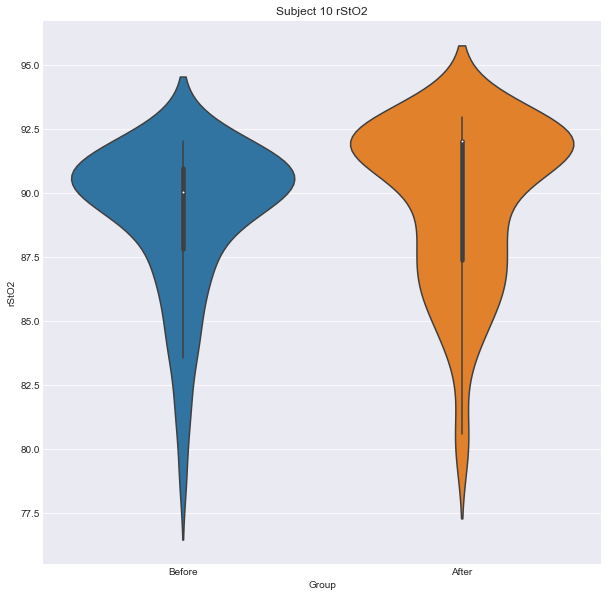

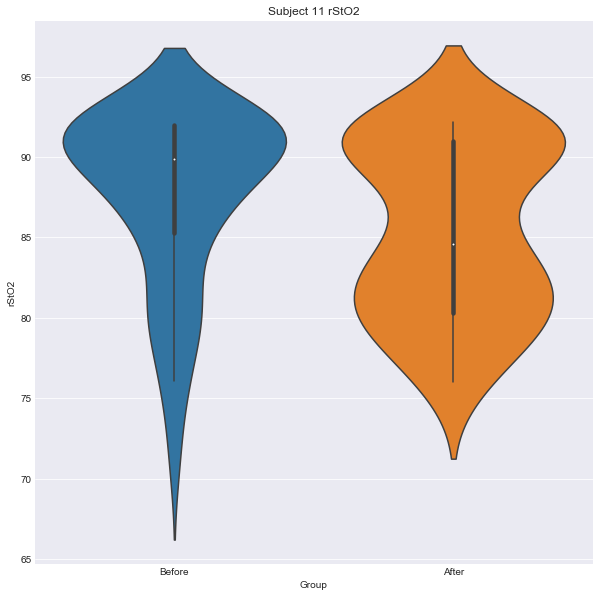

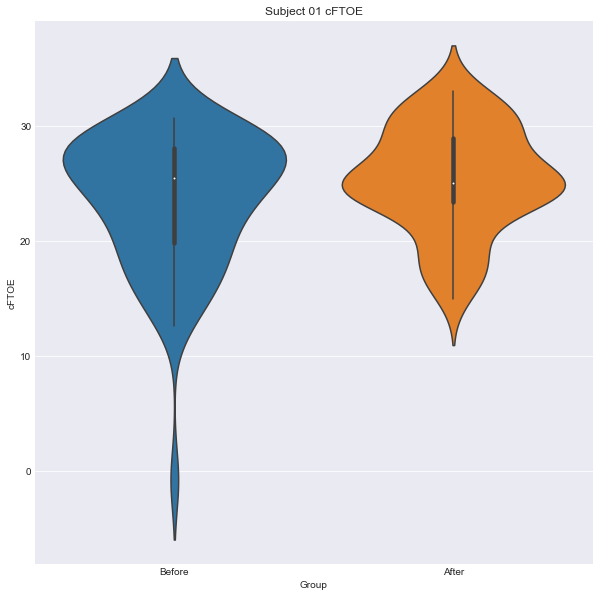

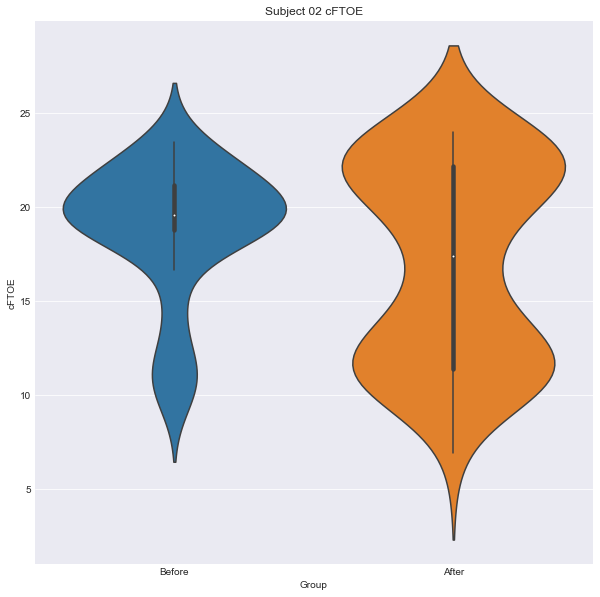

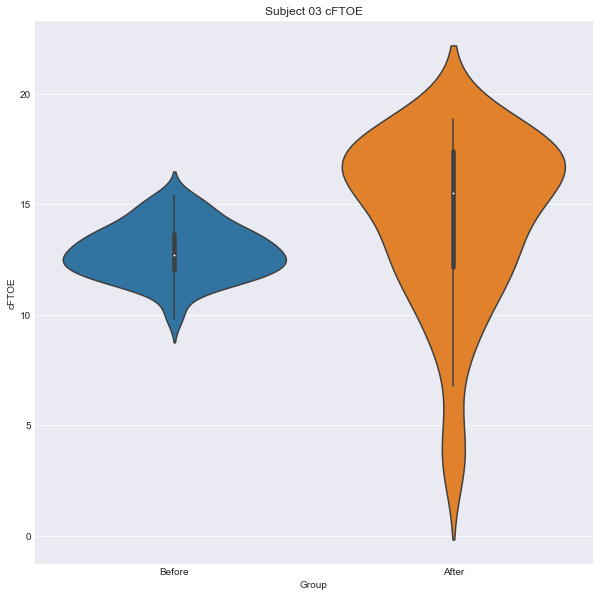

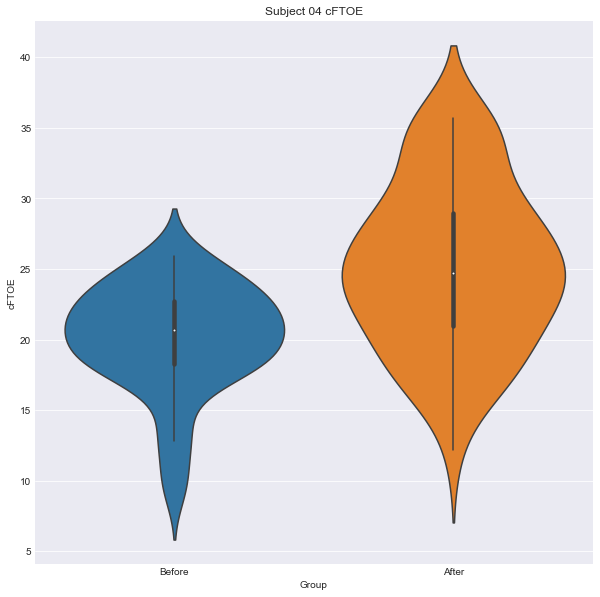

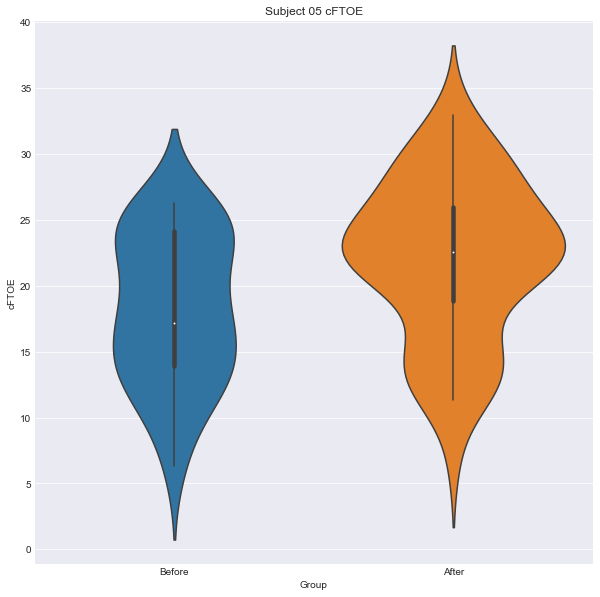

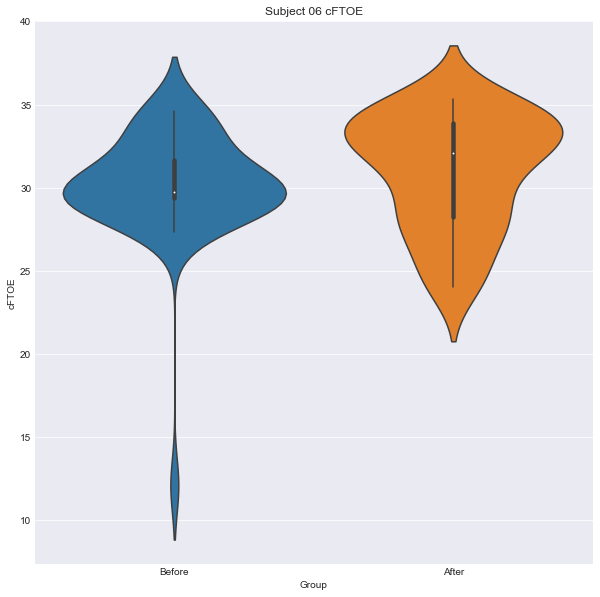

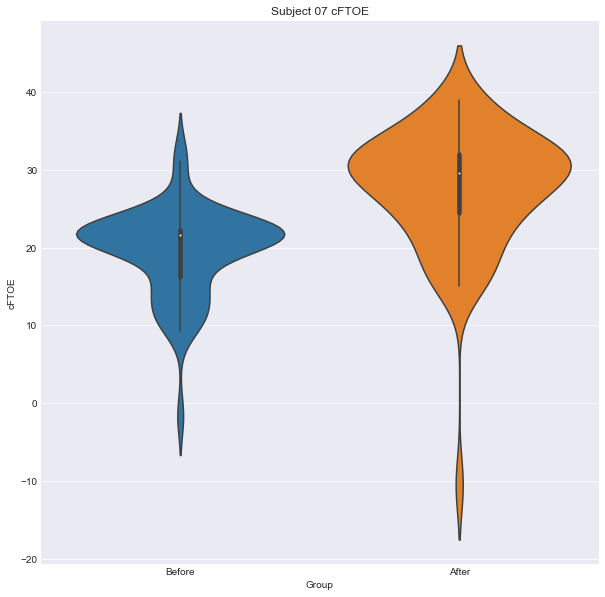

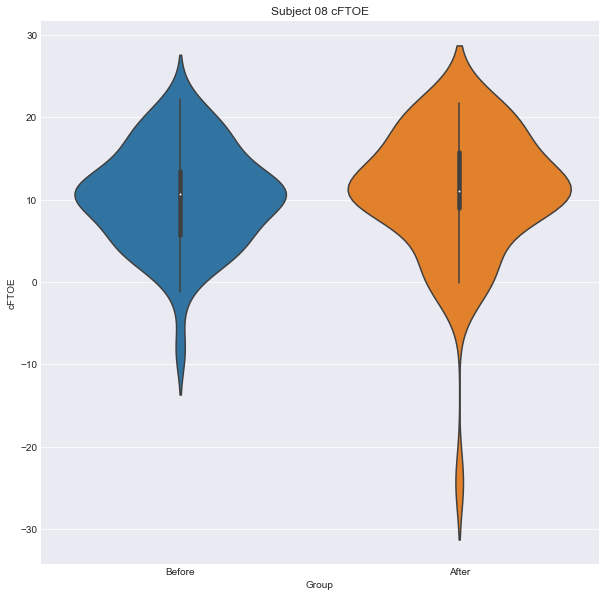

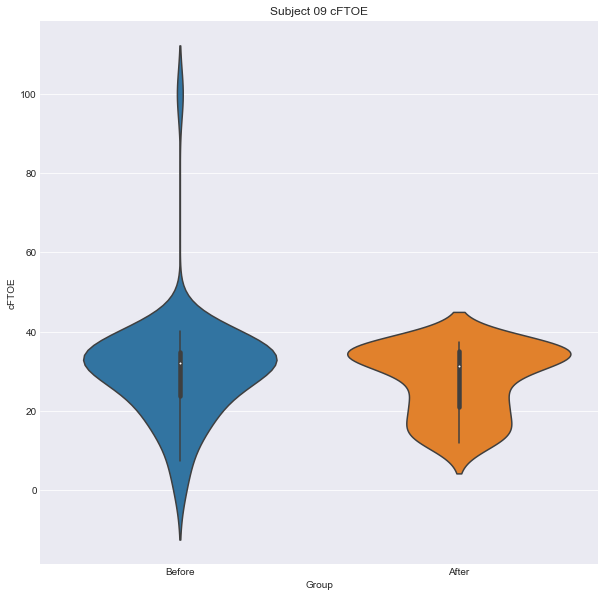

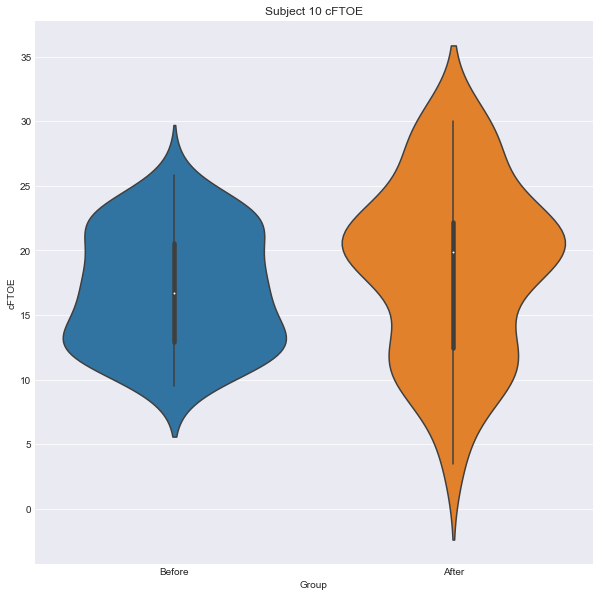

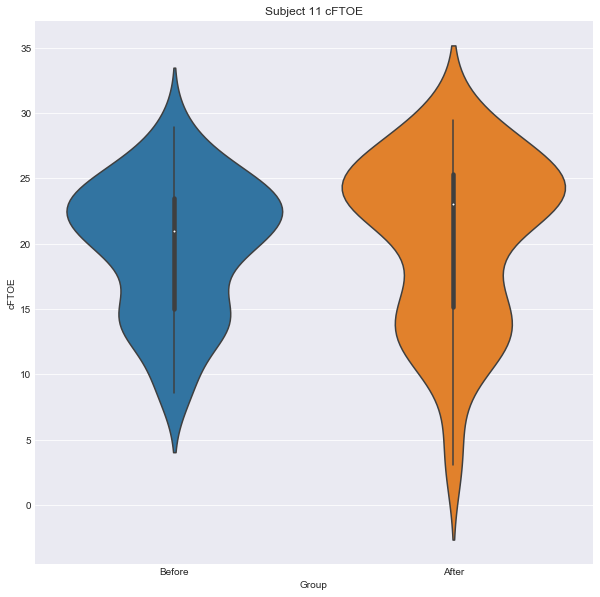

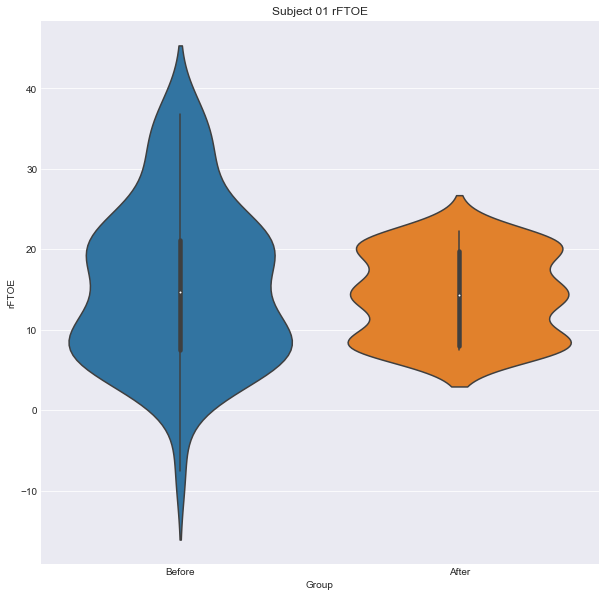

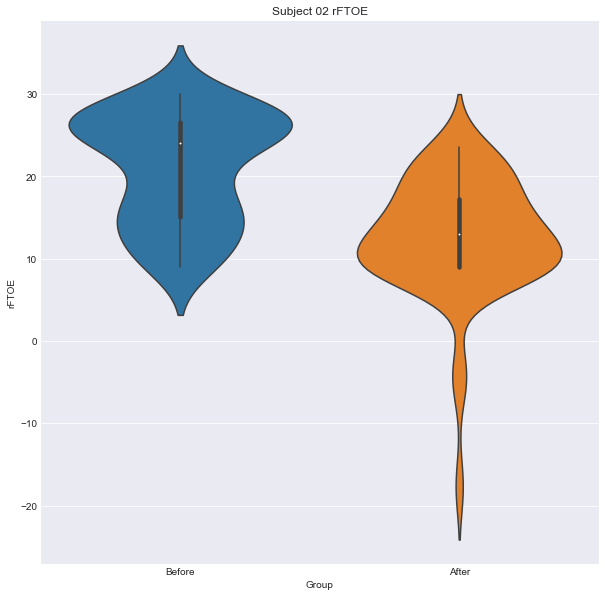

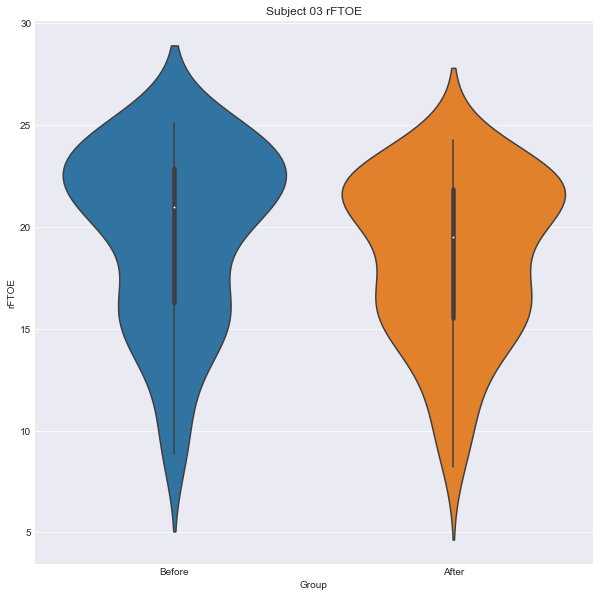

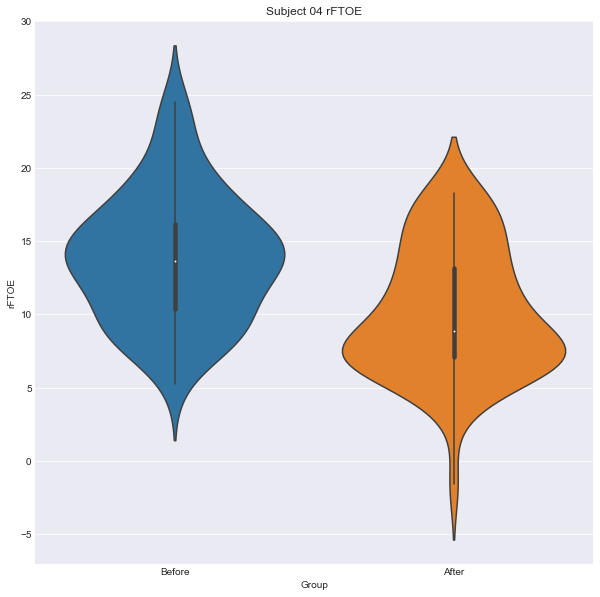

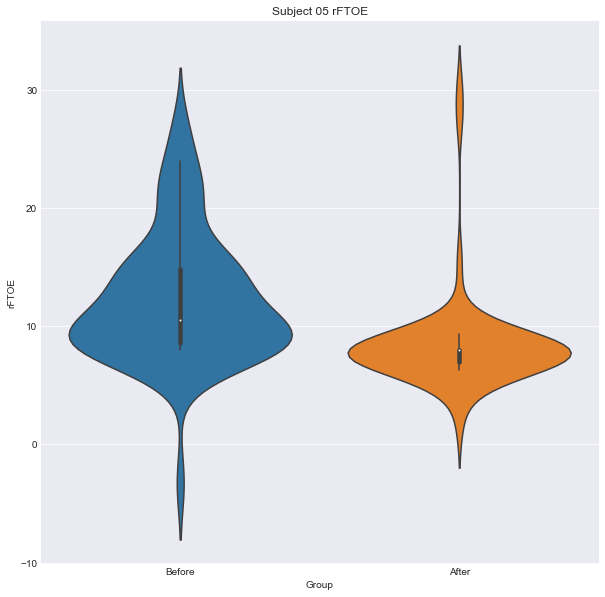

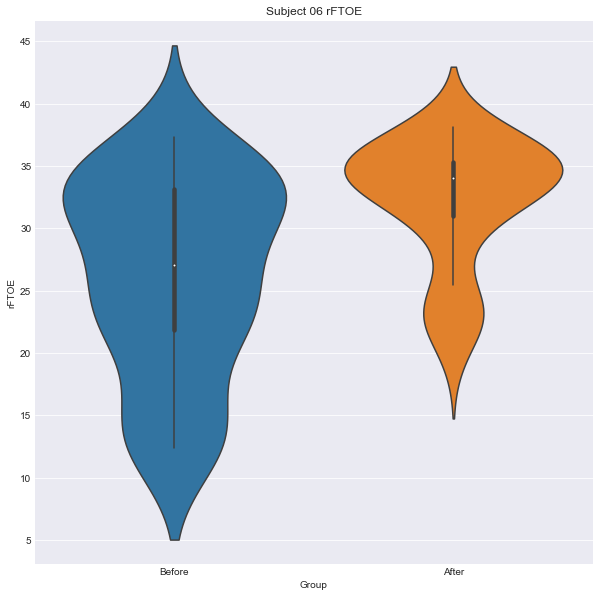

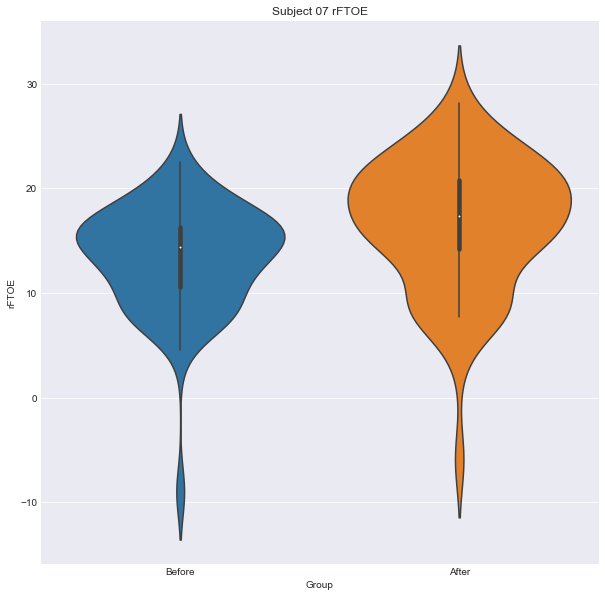

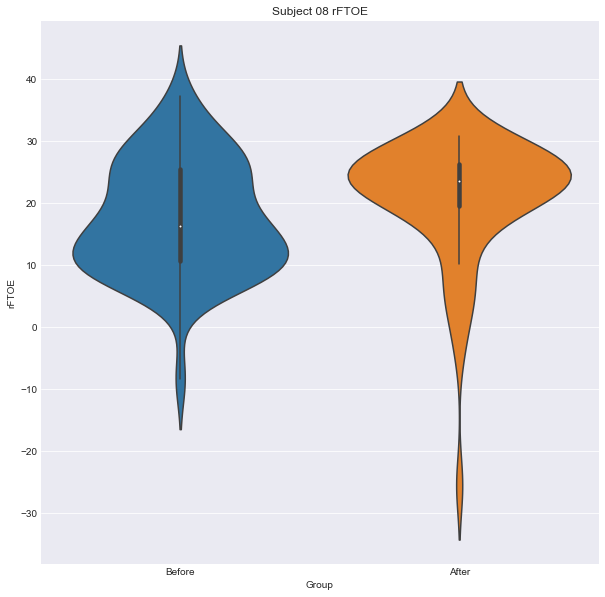

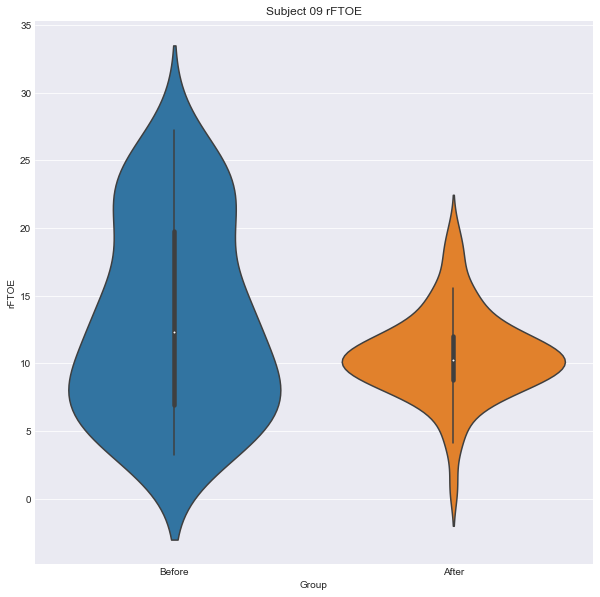

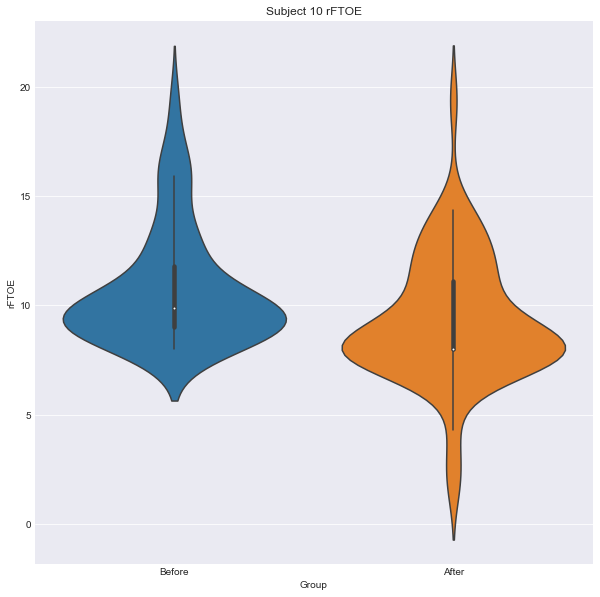

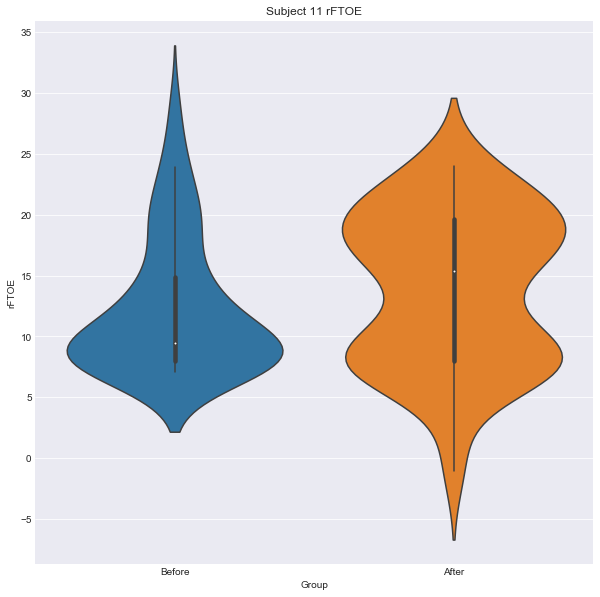

In [33]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-darkgrid')

for var in varlst[1:11]:
    for i in Subject_lst:
        sns.violinplot(x="Group", y=var, data=dfc.loc[data['Subject'] == i], order = ['Before', 'After'], scale='count', inner='box')
        plt.title('Subject '+ i + ' ' + var)
        plt.show()

### Outlier Removal
Due to the 1 minute averaged nature of the data, no outliers have been removed. However, GTP008 showed a very obvious SpO2 outlier at 10:38 and it was manually removed from the raw data file. 

## Correlations Before and After

In [18]:
display_sbs(dfb.groupby('Subject').corr(), dfa.groupby('Subject').corr())

C3-P3 
 C4-P4 
 HR 
 MAP 
 RR 
 SpO2 
 cFTOE 
 cStO2 
 rFTOE 
 rStO2 
 
 
 Subject 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 01 
 C3-P3 
 1.000000 
 0.262520 
 -0.464568 
 0.479397 
 0.152111 
 0.304598 
 0.333351 
 -0.021672 
 -0.000458 
 0.167693 
 
 
 C4-P4 
 0.262520 
 1.000000 
 -0.370474 
 0.827354 
 -0.090994 
 -0.317917 
 -0.053458 
 -0.271786 
 0.232004 
 -0.379501 
 
 
 HR 
 -0.464568 
 -0.370474 
 1.000000 
 NaN 
 -0.176452 
 -0.387881 
 -0.143006 
 -0.604053 
 0.707342 
 -0.843836 
 
 
 MAP 
 0.479397 
 0.827354 
 NaN 
 1.000000 
 NaN 
 -0.054016 
 0.106897 
 -0.126266 
 0.816585 
 -0.782168 
 
 
 RR 
 0.152111 
 -0.090994 
 -0.176452 
 NaN 
 1.000000 
 0.223707 
 0.147070 
 0.211865 
 -0.089225 
 0.198208 
 
 
 SpO2 
 0.304598 
 -0.317917 
 -0.387881 
 -0.054016 
 0.223707 
 1.000000 
 0.616842 
 0.453344 
 0.056141 
 0.508798 
 
 
 cFTOE 
 0.333351 
 -0.053458 
 -0.143006 
 0.106897 
 0.147070 
 0.616842 
 1.000000 
 -0.415282 
 0.268242 
 0.127900 
 
 
 cStO2 
 -0.021672 
 -0.271786 
 -0.604053 
 -0.126266 
 0.211865 
 0.453344 
 -0.415282 
 1.000000 
 -0.192582 
 0.407757 
 
 
 rFTOE 
 -0.000458 
 0.232004 
 0.707342 
 0.816585 
 -0.089225 
 0.056141 
 0.268242 
 -0.192582 
 1.000000 
 -0.828158 
 
 
 rStO2 
 0.167693 
 -0.379501 
 -0.843836 
 -0.782168 
 0.198208 
 0.508798 
 0.127900 
 0.407757 
 -0.828158 
 1.000000 
 
 
 02 
 C3-P3 
 1.000000 
 -0.030383 
 0.449494 
 -0.019813 
 0.353044 
 0.074427 
 0.301843 
 -0.287072 
 0.486488 
 -0.470135 
 
 
 C4-P4 
 -0.030383 
 1.000000 
 -0.367179 
 -0.303904 
 0.205276 
 0.236337 
 -0.360974 
 0.410217 
 -0.576605 
 0.590057 
 
 
 HR 
 0.449494 
 -0.367179 
 1.000000 
 -0.101496 
 -0.131096 
 -0.231594 
 -0.060458 
 -0.038473 
 0.756079 
 -0.775723 
 
 
 MAP 
 -0.019813 
 -0.303904 
 -0.101496 
 1.000000 
 0.029756 
 -0.157456 
 0.658417 
 -0.716072 
 0.384947 
 -0.395209 
 
 
 RR 
 0.353044 
 0.205276 
 -0.131096 
 0.029756 
 1.000000 
 0.251953 
 0.371810 
 -0.309894 
 0.116950 
 -0.081858 
 
 
 SpO2 
 0.074427 
 0.236337 
 -0.231594 
 -0.157456 
 0.251953 
 1.000000 
 0.108539 
 0.098210 
 -0.131886 
 0.229464 
 
 
 cFTOE 
 0.301843 
 -0.360974 
 -0.060458 
 0.658417 
 0.371810 
 0.108539 
 1.000000 
 -0.978610 
 0.714180 
 -0.690616 
 
 
 cStO2 
 -0.287072 
 0.410217 
 -0.038473 
 -0.716072 
 -0.309894 
 0.098210 
 -0.978610 
 1.000000 
 -0.741918 
 0.738531 
 
 
 rFTOE 
 0.486488 
 -0.576605 
 0.756079 
 0.384947 
 0.116950 
 -0.131886 
 0.714180 
 -0.741918 
 1.000000 
 -0.995073 
 
 
 rStO2 
 -0.470135 
 0.590057 
 -0.775723 
 -0.395209 
 -0.081858 
 0.229464 
 -0.690616 
 0.738531 
 -0.995073 
 1.000000 
 
 
 03 
 C3-P3 
 1.000000 
 0.427107 
 0.128717 
 -0.499550 
 -0.065754 
 0.153945 
 0.006357 
 0.085518 
 0.016384 
 0.005673 
 
 
 C4-P4 
 0.427107 
 1.000000 
 -0.001824 
 0.625905 
 0.119923 
 -0.053746 
 0.123501 
 -0.156424 
 -0.033331 
 0.024258 
 
 
 HR 
 0.128717 
 -0.001824 
 1.000000 
 0.865054 
 -0.426389 
 -0.466241 
 -0.441140 
 0.164640 
 0.319268 
 -0.363822 
 
 
 MAP 
 -0.499550 
 0.625905 
 0.865054 
 1.000000 
 -0.381390 
 -0.956478 
 -0.497538 
 -0.116143 
 0.485571 
 -0.639770 
 
 
 RR 
 -0.065754 
 0.119923 
 -0.426389 
 -0.381390 
 1.000000 
 0.165576 
 0.198734 
 -0.101572 
 0.003514 
 0.019796 
 
 
 SpO2 
 0.153945 
 -0.053746 
 -0.466241 
 -0.956478 
 0.165576 
 1.000000 
 0.303593 
 0.292611 
 -0.398438 
 0.510584 
 
 
 cFTOE 
 0.006357 
 0.123501 
 -0.441140 
 -0.497538 
 0.198734 
 0.303593 
 1.000000 
 -0.822235 
 -0.141332 
 0.174678 
 
 
 cStO2 
 0.085518 
 -0.156424 
 0.164640 
 -0.116143 
 -0.101572 
 0.292611 
 -0.822235 
 1.000000 
 -0.096230 
 0.129744 
 
 
 rFTOE 
 0.016384 
 -0.033331 
 0.319268 
 0.485571 
 0.003514 
 -0.398438 
 -0.141332 
 -0.096230 
 1.000000 
 -0.992058 
 
 
 rStO2 
 0.005673 
 0.024258 
 -0.363822 
 -0.639770 
 0.019796 
 0.510584 
 0.174678 
 0.129744 
 -0.992058 
 1.000000 
 
 
 04 
 C3-P3 
 1.000000 
 0.613042 
 -0.761874 
 NaN 
 -0.063299 
 0.328937 
 0.412475 
 -0.261716 
 -0.422115 
 0.564050 
 
 


In [19]:
print('All Subjects 1 Hour Before')
display(dfb.corr())

print('All Subjects 1 Hour After')
display(dfa.corr())

All Subjects 1 Hour Before


HR        RR      SpO2       MAP     C3-P3     C4-P4     cStO2  \
HR     1.000000  0.219908 -0.365193  0.072707 -0.210117 -0.305821 -0.353572   
RR     0.219908  1.000000 -0.082985 -0.118626  0.026116  0.106347 -0.103387   
SpO2  -0.365193 -0.082985  1.000000 -0.152501  0.011893  0.052544  0.304922   
MAP    0.072707 -0.118626 -0.152501  1.000000 -0.031410 -0.025165 -0.129471   
C3-P3 -0.210117  0.026116  0.011893 -0.031410  1.000000  0.050227  0.038527   
C4-P4 -0.305821  0.106347  0.052544 -0.025165  0.050227  1.000000  0.229019   
cStO2 -0.353572 -0.103387  0.304922 -0.129471  0.038527  0.229019  1.000000   
rStO2 -0.618720  0.048151  0.324442 -0.378905  0.295175  0.147447  0.309529   
cFTOE  0.264941  0.092930  0.042552  0.036090 -0.046340 -0.245220 -0.937508   
rFTOE  0.507975  0.006932  0.054411  0.317270 -0.289239 -0.158059 -0.166236   

          rStO2     cFTOE     rFTOE  
HR    -0.618720  0.264941  0.507975  
RR     0.048151  0.092930  0.006932  
SpO2   0.324442  0.042552  0.054411  
MAP   -0.378905  0.036090  0.317270  
C3-P3  0.295175 -0.046340 -0.289239  
C4-P4  0.147447 -0.245220 -0.158059  
cStO2  0.309529 -0.937508 -0.166236  
rStO2  1.000000 -0.173550 -0.925578  
cFTOE -0.173550  1.000000  0.205761  
rFTOE -0.925578  0.205761  1.000000

All Subjects 1 Hour After


HR        RR      SpO2       MAP     C3-P3     C4-P4     cStO2  \
HR     1.000000  0.292475 -0.183138  0.070791 -0.113080 -0.460346 -0.419642   
RR     0.292475  1.000000 -0.105612  0.034460 -0.128436 -0.190372 -0.174432   
SpO2  -0.183138 -0.105612  1.000000 -0.374412  0.191190  0.083608  0.237498   
MAP    0.070791  0.034460 -0.374412  1.000000  0.007692  0.242839 -0.702123   
C3-P3 -0.113080 -0.128436  0.191190  0.007692  1.000000  0.266092 -0.012952   
C4-P4 -0.460346 -0.190372  0.083608  0.242839  0.266092  1.000000  0.162782   
cStO2 -0.419642 -0.174432  0.237498 -0.702123 -0.012952  0.162782  1.000000   
rStO2  0.028421  0.099698  0.280262 -0.107079  0.150816 -0.036052  0.231015   
cFTOE  0.399996  0.139385  0.182539  0.446634  0.074796 -0.131122 -0.908374   
rFTOE -0.177210 -0.201872  0.178503 -0.160655 -0.074133  0.067231 -0.157817   

          rStO2     cFTOE     rFTOE  
HR     0.028421  0.399996 -0.177210  
RR     0.099698  0.139385 -0.201872  
SpO2   0.280262  0.182539  0.178503  
MAP   -0.107079  0.446634 -0.160655  
C3-P3  0.150816  0.074796 -0.074133  
C4-P4 -0.036052 -0.131122  0.067231  
cStO2  0.231015 -0.908374 -0.157817  
rStO2  1.000000 -0.144534 -0.892121  
cFTOE -0.144534  1.000000  0.242745  
rFTOE -0.892121  0.242745  1.000000

In [20]:
# Double Check 1 Hour After FTOE Values
dfa[['cFTOE', 'rFTOE']].describe()

cFTOE       rFTOE
count  639.000000  634.000000
mean    21.603078   14.706894
std      8.505255    8.182804
min    -24.322588  -25.484548
25%     15.500564    8.000000
50%     22.148100   13.356551
75%     27.981929   20.199590
max     39.000000   38.148100

#### Between Subject comparisons - combined data 1 Hour Before and 1 Hour After

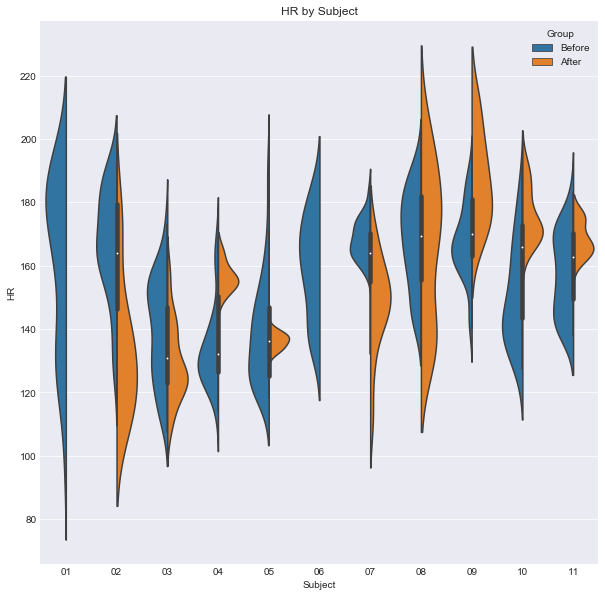

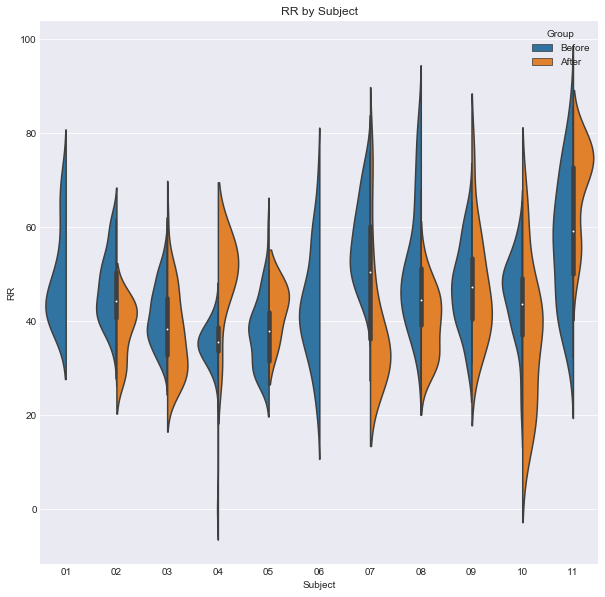

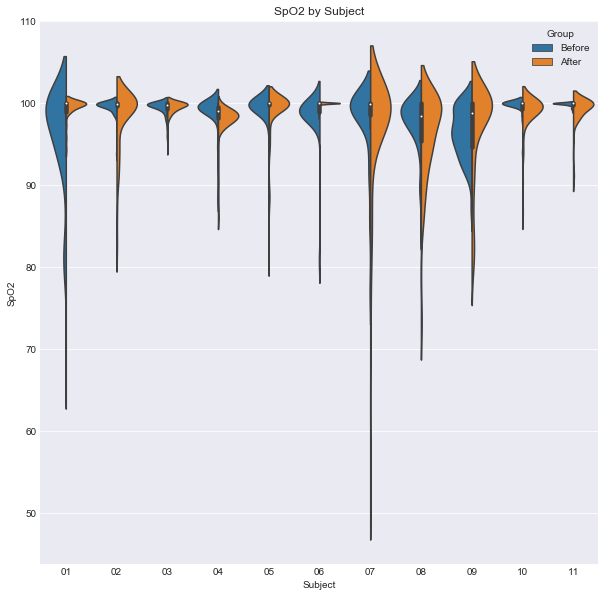

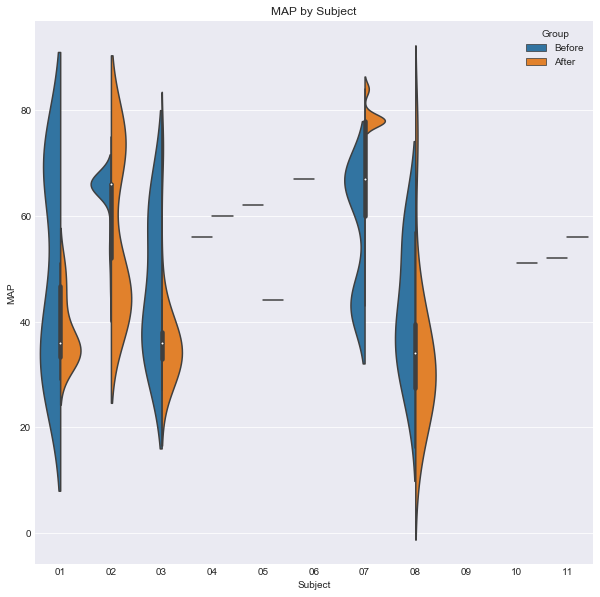

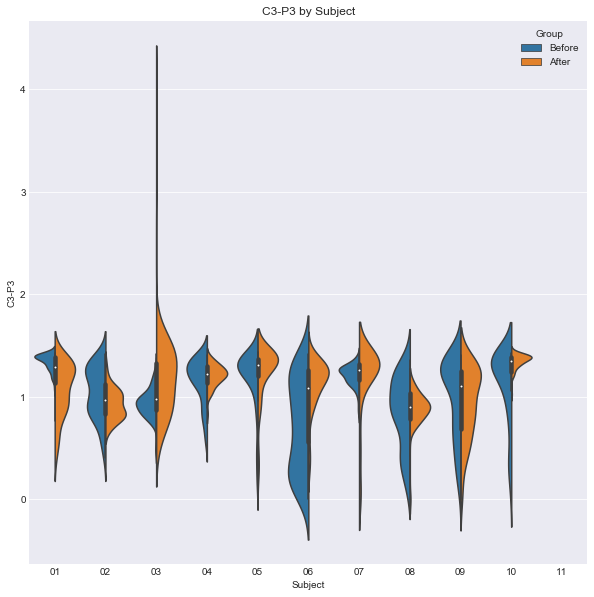

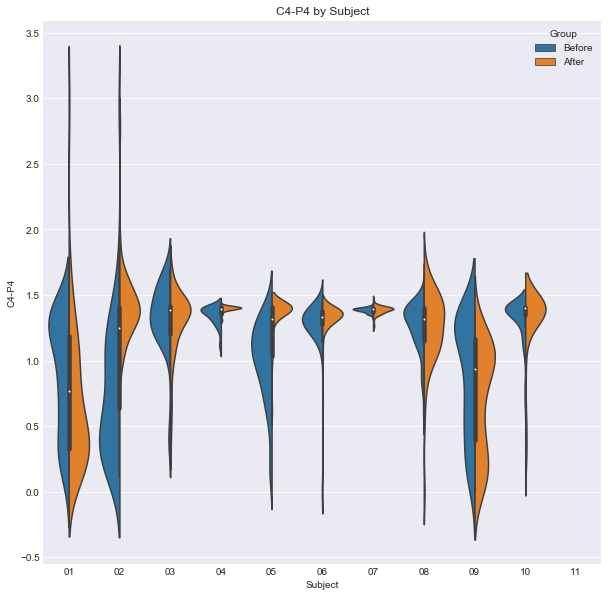

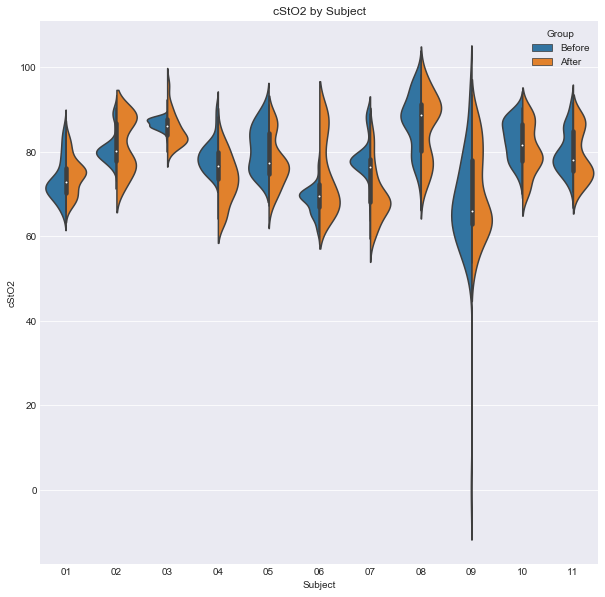

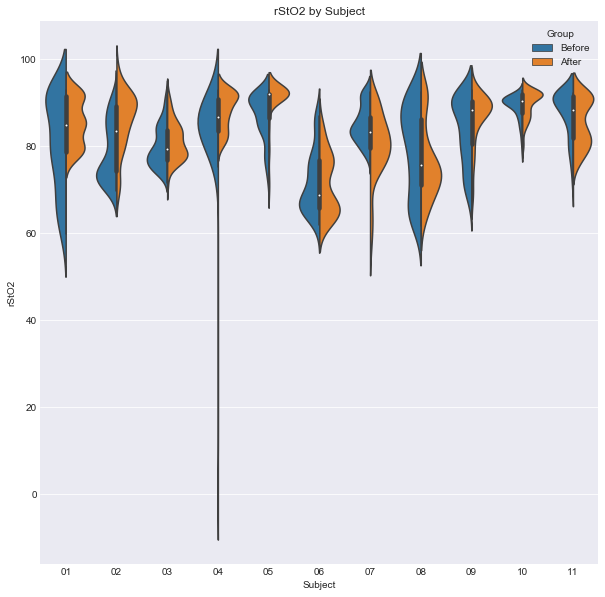

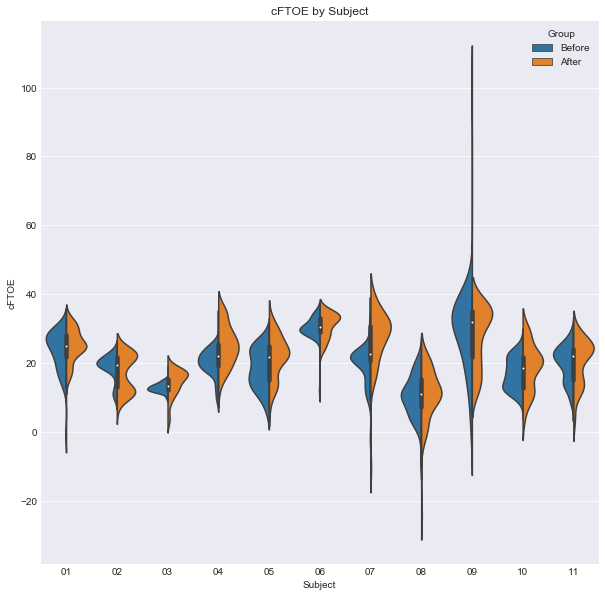

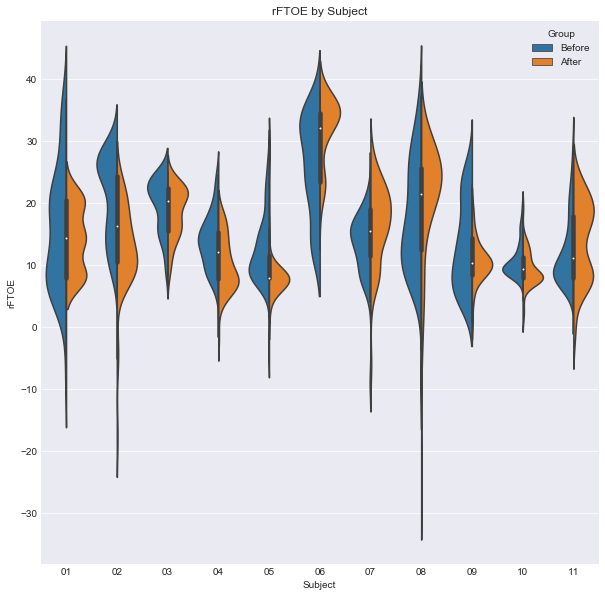

In [22]:
for var in varlst[1:11]:
    ax = sns.violinplot(x ='Subject', y=var, data=dfc, hue='Group', scale='width', split=True)
    plt.title(var + ' by Subject')
    plt.show()

#### All Subjects Stratified by Group

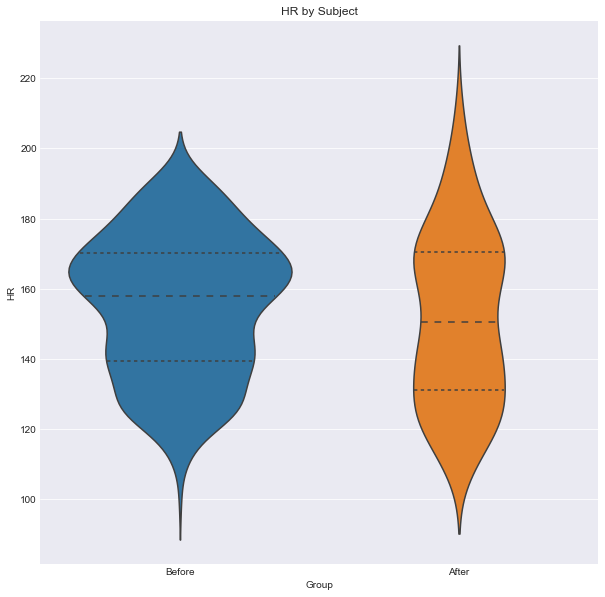

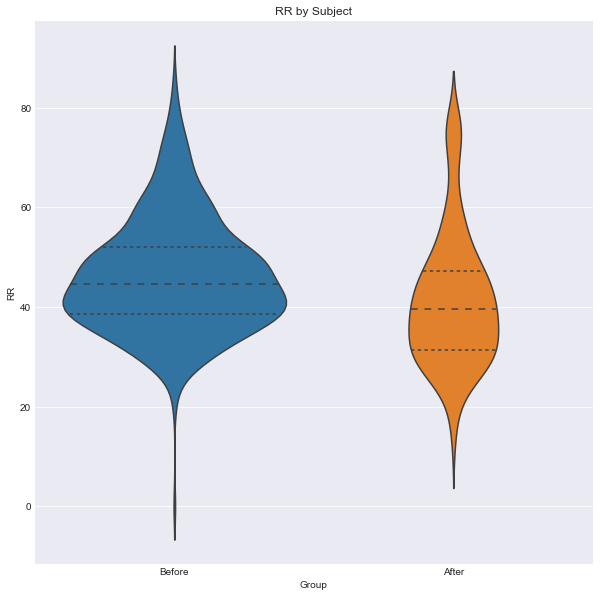

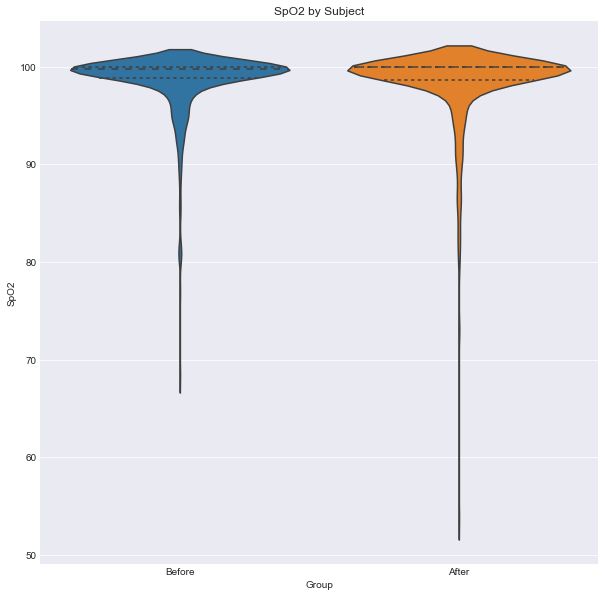

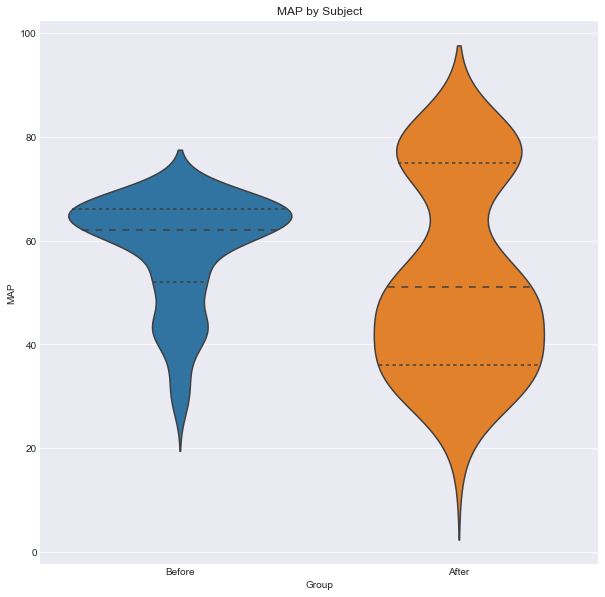

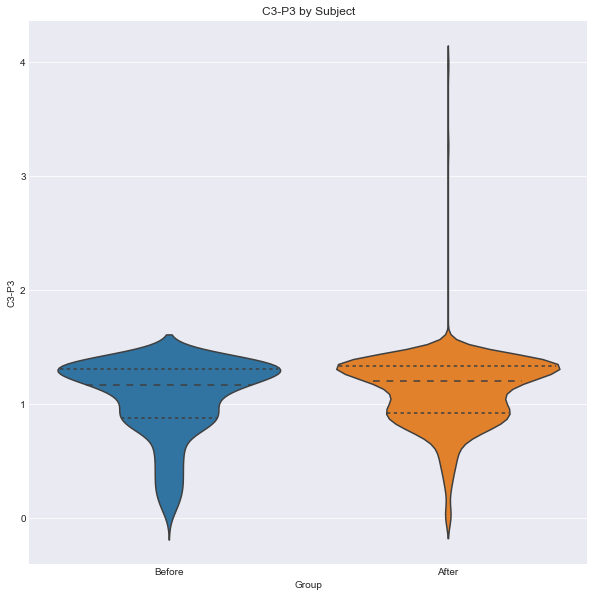

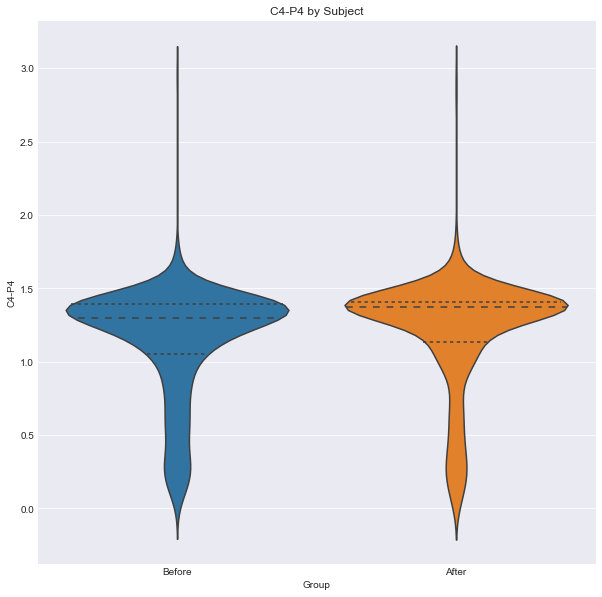

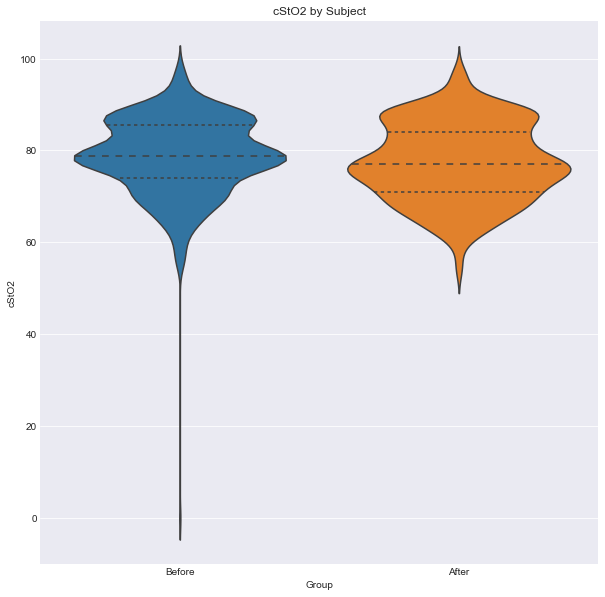

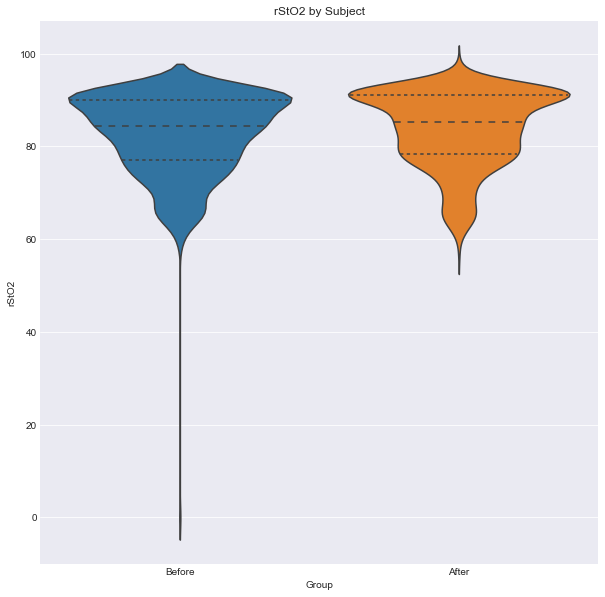

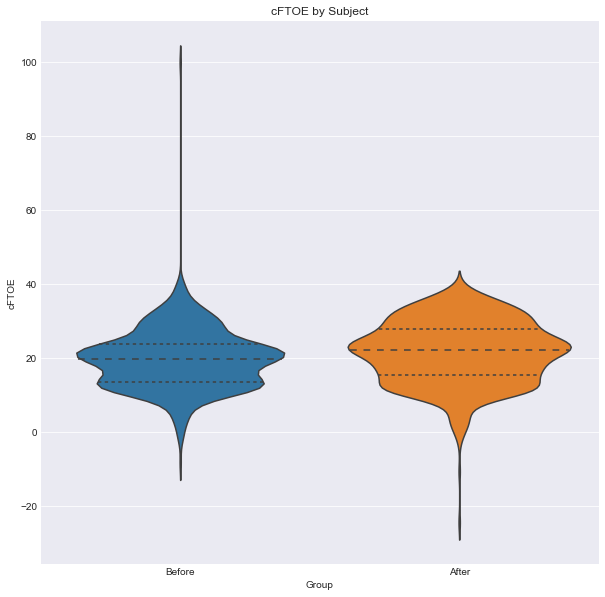

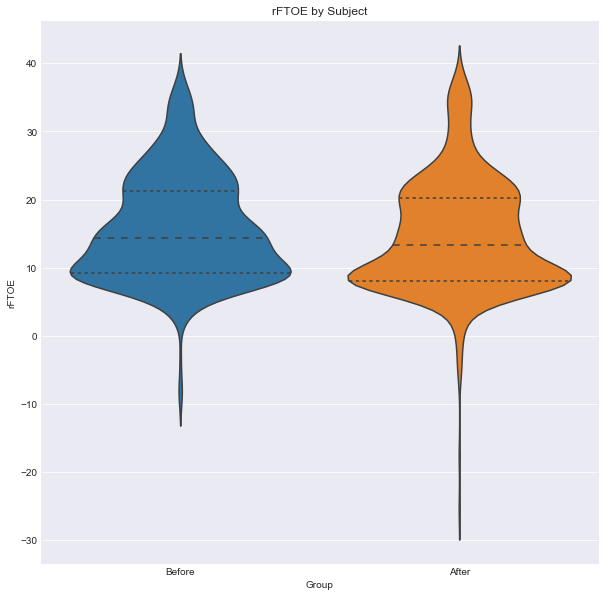

In [40]:
for var in varlst[1:11]:
    ax = sns.violinplot(x ='Group', y=var, data=dfc, scale='count', inner='quartile')
    plt.title(var + ' by Subject')
    plt.show()